In [1]:
from scipy.io import arff
from io import StringIO
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import math
from scipy import stats
import keras
from keras import backend as K
import pandas as pd
import neupy
from neupy import init, layers, algorithms
import sklearn
from sklearn import metrics,model_selection


Using TensorFlow backend.
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

## 4. Построение и исследование нейросетевых моделей

In [2]:
p = { "attr_count": 11
}

In [3]:
file_content = ""
with open("pretreatmented.arff") as file:
    file_content = StringIO(file.read())
dataset, meta = arff.loadarff(file_content)

In [4]:
data = [[] for i in range(0, p["attr_count"])]
for i in range(0, p["attr_count"]):
    data[i] = dataset[i+1]


In [5]:
train_params = {
    "inputs": 10,
    "outputs": 1,
    "hidden": [20,10,10],
    "activations":["tanh", "tanh", "tanh", "sigmoid"],
    "batch": 50,
    "initializer": keras.initializers.glorot_normal(0),
    "initializer_neupy": neupy.init.XavierNormal(seed=0),
    "epochs": 200
}

In [6]:
attributes = [] # элемент = строка признаков
results = []
for vector in dataset:
    line = []
    for i in range(0, len(vector)):
        if i == len(vector) - 1:
            results.append(float(vector[i]))
            continue
        line.append(float(vector[i]))
    attributes.append(np.array(line))
attributes = np.array(attributes)
results = np.array(results)

In [7]:
results

array([1., 1., 1., ..., 0., 0., 0.])

In [8]:
print(len(dataset))

3998


In [9]:
print(len(attributes))

3998


In [10]:
print(len(results[results==0]), len(results[results==1]), len(results[results==1])/len(results[results==0]))

2469 1529 0.6192790603483191


### 4.1. Параметры архитектуры и обучения многослойной нейронной сети

In [11]:
values_dict = {
    'train': [1, 2, 3, 6, 8, 9],
    'valid': [0, 4, 7],
    'test' : [5]
}
v_train = { "x":[], "y":[] }
v_valid = { "x":[], "y":[] }
v_test = { "x":[], "y":[] }
train_attrs = attributes
for i in range(0, len(train_attrs)):
    if (i % 10) in values_dict['train']:
        v_train["x"].append(train_attrs[i])
        v_train["y"].append(results[i])
    elif (i % 10) in values_dict['valid']:
        v_valid["x"].append(train_attrs[i])
        v_valid["y"].append(results[i])
    else:
        v_test["x"].append(train_attrs[i])
        v_test["y"].append(results[i])
v_train["x"] = np.array(v_train["x"])
v_train["y"] = np.array(v_train["y"])
v_valid["x"] = np.array(v_valid["x"])
v_valid["y"] = np.array(v_valid["y"])
v_test["x"] = np.array(v_test["x"])
v_test["y"] = np.array(v_test["y"])

In [12]:
def keras_create_model():
    return keras.models.Sequential(
        [
            keras.layers.Dense(
                train_params["hidden"][0], 
                input_dim = train_params["inputs"], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][0]
            ),
            keras.layers.Dense(
                train_params["hidden"][1], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][1]
            ),
            keras.layers.Dense(
                train_params["hidden"][2], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][2]
            ),
            keras.layers.Dense(
                train_params["outputs"], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][3]
            )
        ]
    )

In [13]:
class KerasErrorCollectorCallback(keras.callbacks.Callback):
    def __init__(self):
        self.errors = {
            "train":[],
            "valid":[],
            "test":[]
        }
        
    def on_epoch_end(self, epoch, logs={}):        
        train_error = self.model.evaluate(v_train["x"], v_train["y"], verbose = 0, batch_size = len(v_train["x"]))
        valid_error = self.model.evaluate(v_valid["x"], v_valid["y"], verbose = 0, batch_size = len(v_valid["x"]))
        test_error = self.model.evaluate(v_test["x"], v_test["y"], verbose = 0, batch_size = len(v_test["x"]))
        self.errors["train"].append(train_error)
        self.errors["valid"].append(valid_error)
        self.errors["test"].append(test_error)
    
class KerasEarlyStoppingCallback(keras.callbacks.Callback):
    def __init__(self, waiting_epochs, delta):
        self.waiting_epochs = waiting_epochs
        self.delta = delta
        self.best_epoch = 0
        self.min_error = 10**3
        self.waited_epochs = 0
        self.was_early_stopping = False
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        if self.was_early_stopping:
            return
        valid_error = self.model.evaluate(v_valid["x"], v_valid["y"], verbose = 0, batch_size = len(v_valid["x"]))
        if valid_error < self.min_error:
            self.best_epoch = self.epoch
            self.min_error = valid_error 
            if self.waited_epochs > 0:
                self.waited_epochs -= 2
        else:
            if self.waited_epochs > self.waiting_epochs:
                self.was_early_stopping = True
                return
            if valid_error - self.min_error > self.delta:
                self.waited_epochs += 1
            self.waited_epochs += 1
            
from functools import reduce
class KerasLearningRateCallback(keras.callbacks.Callback):
    def __init__(self, neurons, x, y, b_size):
        self.neurons = neurons #Словарь вида {номер_слоя:(i, j)....}, (i, j) - номер веса в матрице
        self.x = x
        self.y = y
        self.b_size = b_size
        
    def on_train_begin(self, logs={}):
        weights = self.model.trainable_weights 
        current_lr = np.array(self.model.optimizer.lr)#(self.model.total_loss, weights)
        input_tensors = [self.model.inputs[0], # input data
                 self.model.sample_weights[0], # how much to weight each sample by
                 self.model.targets[0], # labels
                 K.learning_phase(), # train or test mode
        ]
        self.get_current_lr = K.function(inputs=input_tensors, outputs= current_lr)
        
        self.max_lr = []
        self.min_lr = []
        self.mean_lr = []
        self.neuron_lr = []
        for i in self.neurons:
            self.neuron_lr.append([])

    def on_epoch_begin(self, batch, logs={}):
        start = batch*self.b_size  #начало батча
        end = (batch+1)*self.b_size if batch*self.b_size < len(self.x) else len(self.x)  #конец батча
        inputs = [self.x[start:end], # X
          [1], # sample weights
          self.y[start:end], # y
          0 # learning phase in TEST mode
        ]
        current_lr = self.get_current_lr(inputs) # список матриц, содержащих lr для каждого слоя
        max_lr = []
        min_lr=[]
        sum_lr = []
        for layer, neuron in self.neurons.items():
            bias, weights = current_lr[2*(layer-1):2*layer][1].reshape(1, -1), current_lr[2*(layer-1):2*layer][0]
            current_lr_layer = np.concatenate([bias, weights], axis=0)
            self.neuron_lr[layer-1].append(current_lr_layer[neuron])
            max_lr.append(np.max(current_lr_layer))
            min_lr.append(np.min(current_lr_layer))
            sum_lr.append(np.sum(current_lr_layer))
        self.max_lr.append(max(max_lr))
        self.min_lr.append(min(min_lr))
        self.mean_lr.append(reduce(lambda y, x: y+x, sum_lr)/self.model.count_params())

In [14]:
def keras_fit_model(optimizer, lr = False):
    error_collector = KerasErrorCollectorCallback()
    early_stopping = KerasEarlyStoppingCallback(waiting_epochs=30, delta=0.01)
    learning_rate = KerasLearningRateCallback(
        {1:(3, 5), 2:(4, 2), 3:(9, 2), 4:(2, 6)}, v_train["x"], v_train["y"], train_params["batch"]
    )
    callbacks = [error_collector, early_stopping]
    if lr:
        callbacks.append(learning_rate)
    model = keras_create_model()
    model.compile(
        loss = "binary_crossentropy", 
        optimizer = optimizer,
        metrics = []
    )
    history = model.fit(
        v_train["x"],
        v_train["y"],
        epochs = train_params["epochs"],
        verbose = 0,
        batch_size = train_params["batch"],
        callbacks = callbacks
    )
    return error_collector, early_stopping, learning_rate

In [15]:
def keras_train_and_get_info(optimizer, lr = False):
    error_collector, early_stopping, learning_rate = keras_fit_model(
        optimizer, lr
    )
    best_epoch = early_stopping.best_epoch
    info = [
        best_epoch,
        error_collector.errors["train"][best_epoch-1],
        error_collector.errors["test"][best_epoch-1]
    ]
    if lr:
        return info, error_collector, learning_rate
    return info, error_collector

In [16]:
def keras_show_tvt_values(error_collector):
    _, picture = plt.subplots(figsize=(25,10))
    _ = picture.plot(error_collector.errors["train"], lw=3, label="На обучающей")
    _ = picture.plot(error_collector.errors["valid"], lw=3, label="На валидационной")
    _ = picture.plot(error_collector.errors["test"], lw=3, label="На тестовой")
    _ = picture.legend()

In [17]:
def keras_show_learning_rates(lr_curve, title):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(lr_curve.max_lr)+1),lr_curve.max_lr, label='Max lr')
    plt.plot(range(1,len(lr_curve.min_lr)+1),lr_curve.min_lr,label='Min lr')
    plt.plot(range(1,len(lr_curve.mean_lr)+1),lr_curve.mean_lr,label='Mean lr')
    plt.xlabel('batch')
    plt.ylabel('lr')
    fig.suptitle(title, fontsize="x-large")
    
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    for layer, neuron in lr_curve.neurons.items():
        plt.plot(range(1,len(lr_curve.neuron_lr[layer-1])+1),lr_curve.neuron_lr[layer-1], label='Layer {}, w[{},{}]'.format(layer, neuron[0],neuron[1]))
    plt.xlabel('batch')
    plt.ylabel('lr')
    fig.suptitle(title, fontsize="x-large")
    
    plt.legend()
    plt.show()

In [18]:
def neupy_create_model():
    return neupy.layers.join(
        neupy.layers.Input(train_params["inputs"]),
        neupy.layers.Tanh(train_params["hidden"][0], weight=train_params["initializer_neupy"]),
        neupy.layers.Tanh(train_params["hidden"][1], weight=train_params["initializer_neupy"]),
        neupy.layers.Tanh(train_params["hidden"][2], weight=train_params["initializer_neupy"]),
        neupy.layers.Sigmoid(train_params["outputs"], weight=train_params["initializer_neupy"])
    )

In [19]:
flag_use_MSE = False
class NeupyErrorCollectorSignal(object):
    def __init__(self):
        self.errors = {
            "train":[],
            "valid":[],
            "test":[]
        }
        
    def epoch_end(self, optimizer):
        train_error = 0
        if flag_use_MSE:
            train_error = sklearn.metrics.mean_squared_error(v_train["y"], optimizer.predict(v_train["x"]).flatten())
        else:
            train_error = sklearn.metrics.log_loss(v_train["y"], optimizer.predict(v_train["x"]).flatten())
        self.errors["train"].append(train_error)
        
        valid_error = 0
        if flag_use_MSE:
            valid_error = sklearn.metrics.mean_squared_error(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        else:
            valid_error = sklearn.metrics.log_loss(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        self.errors["valid"].append(valid_error)
        
        test_error = 0
        if flag_use_MSE:
            test_error = sklearn.metrics.mean_squared_error(v_test["y"], optimizer.predict(v_test["x"]).flatten())
        else:
            test_error = sklearn.metrics.log_loss(v_test["y"], optimizer.predict(v_test["x"]).flatten())
        self.errors["test"].append(test_error)

class NeupyEarlyStoppingSignal(object):
    def __init__(self, waiting_epochs, delta):
        self.waiting_epochs = waiting_epochs
        self.delta = delta
        self.best_epoch = 0
        self.min_error = 10**3
        self.waited_epochs = 0
        self.was_early_stopping = False
        self.epoch = 0
    
    def epoch_end(self, optimizer):
        self.epoch += 1
        if self.was_early_stopping:
            return
        if flag_use_MSE:
            valid_error = sklearn.metrics.mean_squared_error(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        else:
            valid_error = sklearn.metrics.log_loss(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        if valid_error < self.min_error:
            self.best_epoch = self.epoch
            self.min_error = valid_error
            if self.waited_epochs > 0:
                self.waited_epochs -= 2
        else:
            if self.waited_epochs > self.waiting_epochs:
                self.was_early_stopping = True
                return
            if valid_error - self.min_error > self.delta:
                self.waited_epochs += 1
            self.waited_epochs += 1
            
sess = neupy.utils.tensorflow_session()
class Increment_Curve(object):
    def __init__(self, neurons_numbers):
        self.neurons = neurons_numbers
        
    def train_start(self, optimizer, **kwargs):
        self.max_increment = []
        self.min_increment = []
        self.mean_increment = []
        self.neuron_increment = []
        self.prev_weights = []
        for i in self.neurons:
            self.neuron_increment.append([])
        
    def epoch_end(self, optimizer):
        epoch_increment = np.array([])
        if len(self.prev_weights) > 0:
            for layer, neuron in self.neurons.items():
                weight = sess.run(optimizer.network.layers[layer].weight)
                bias = sess.run(optimizer.network.layers[layer].bias)
                current_weights = np.concatenate([bias.reshape(1, -1), weight], axis=0)
                increment = current_weights - self.prev_weights[layer-1]
                self.neuron_increment[layer-1].append(increment[neuron])
                epoch_increment = np.append(epoch_increment, increment)
                self.prev_weights[layer-1] = current_weights
            self.max_increment.append(epoch_increment.max())
            self.min_increment.append(epoch_increment.min())
            self.mean_increment.append(epoch_increment.mean())
        else:
            for layer, neuron in self.neurons.items():
                weight = K.get_value(optimizer.network.layers[layer].weight)
                bias = K.get_value(optimizer.network.layers[layer].bias)
                current_weights = np.concatenate([bias.reshape(1, -1), weight], axis=0)
                self.prev_weights.append(current_weights) 

In [20]:
def neupy_train_and_get_info(optimizer_name, param = 0, inc = False):
    error_collector = NeupyErrorCollectorSignal()
    early_stopping = NeupyEarlyStoppingSignal(waiting_epochs=30, delta=0.01)
    incr = Increment_Curve({1:(3, 5), 2:(3, 9), 3:(10, 2), 4:(0, 0)})
    callbacks = [error_collector, early_stopping]
    if inc:
        callbacks.append(incr)
    model = neupy_create_model()
    optimizer = None
    if optimizer_name == "RMSProp":
        optimizer = neupy.algorithms.RMSProp(
            network = model, 
            loss = "binary_crossentropy", 
            momentum = param,
            batch_size = train_params["batch"],
            signals = callbacks
        )
    elif optimizer_name == "GD":
        optimizer = neupy.algorithms.GradientDescent(
            network = model, 
            loss = "binary_crossentropy", 
            step = param,
            batch_size = train_params["batch"],
            signals = callbacks
        )
    elif optimizer_name == "Fletcher-Reeeves":
        optimizer = neupy.algorithms.ConjugateGradient(
            network = model,
            loss = "binary_crossentropy",
            update_function = "fletcher_reeves",
            signals = callbacks
        )
    elif optimizer_name == "Polak-Ribiere":
        optimizer = neupy.algorithms.ConjugateGradient(
            network = model,
            loss = "binary_crossentropy",
            update_function = "polak_ribiere",
            signals = callbacks
        )
    elif optimizer_name == "RProp":
        optimizer = neupy.algorithms.RPROP(
            network = model,
            loss = "binary_crossentropy",
            verbose = True,
            signals = callbacks
        )
    elif optimizer_name == "LM":
        optimizer = neupy.algorithms.LevenbergMarquardt(
            network = model,
            signals = callbacks
        )
    elif optimizer_name == "BFGS":
        optimizer = neupy.algorithms.QuasiNewton(
            network = model,
            loss = "binary_crossentropy",
            update_function = "bfgs",
            signals = callbacks
        )
    elif optimizer_name == "SteepestGD":
        optimizer = SteepestGD(
            network = model,
            loss = "binary_crossentropy",
            signals = callbacks
        )
    optimizer.train(
        v_train["x"],
        v_train["y"],
        epochs = train_params["epochs"]
    )
    best_epoch = early_stopping.best_epoch
    info = [
        best_epoch,
        error_collector.errors["train"][best_epoch-1],
        error_collector.errors["test"][best_epoch-1]
    ]
    if inc:
        return info, error_collector, incr
    return info, error_collector

In [21]:
def neupy_show_tvt_values(error_collector):
    _, picture = plt.subplots(figsize=(25,10))
    _ = picture.plot(error_collector.errors["train"], lw=3, label="На обучающей")
    _ = picture.plot(error_collector.errors["valid"], lw=3, label="На валидационной")
    _ = picture.plot(error_collector.errors["test"], lw=3, label="На тестовой")
    _ = picture.legend()

In [22]:
def plot_increment(inc_curve, title):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(inc_curve.max_increment)+1),inc_curve.max_increment, label='Max increment')
    plt.plot(range(1,len(inc_curve.min_increment)+1),inc_curve.min_increment,label='Min increment')
    plt.plot(range(1,len(inc_curve.mean_increment)+1),inc_curve.mean_increment,label='Mean increment')
    
    plt.xlabel('epochs')
    plt.ylabel('increment')
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    for layer, neuron in inc_curve.neurons.items():
        plt.plot(range(1,len(inc_curve.neuron_increment[layer-1])+1),inc_curve.neuron_increment[layer-1], label='Layer {}, w[{},{}]'.format(layer, neuron[0],neuron[1]))
    plt.xlabel('batch')
    plt.ylabel('lr')
    fig.suptitle(title, fontsize="x-large")
    
    plt.grid(True)
    plt.legend()
    plt.show()

### 4.2. Исследование простого градиентного метода обучения

#### а) Исследование влияния параметра скорости обучения на качество обучения

In [23]:
learning_rates_SGD = [0.001, 0.01, 0.1, 0.5, 2]
info_SGD = [
    keras_train_and_get_info(keras.optimizers.SGD(lr=lr))[0]
    for lr in learning_rates_SGD
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### б) Заполнить таблицу по результатам обучения

In [24]:
for i in range(0, len(info_SGD)):
            print(i+1,learning_rates_SGD[i], info_SGD[i][0], round(info_SGD[i][1], 3), round(info_SGD[i][2], 3))


1 0.001 200 0.663 0.663
2 0.01 191 0.276 0.286
3 0.1 48 0.272 0.276
4 0.5 39 0.271 0.278
5 2 31 0.277 0.281


#### в) Выводы

In [25]:
def get_best_lr():
    index = 0
    val_loss = 1
    for i in range(0, len(info_SGD)):
        if info_SGD[i][2] < val_loss:
            val_loss = info_SGD[i][2]
            index = i
    return learning_rates_SGD[index]

train_params["learning_rate"] = get_best_lr()
print("Лучшая скорость обучения $\\alpha$ = {}".format(train_params["learning_rate"]))

Лучшая скорость обучения $\alpha$ = 0.1


### 4.3. Исследование методов GDM и NAG

#### а) Исследование влияния параметра момента на качество обучения

In [26]:
moments_GDM_NAG = [0.0, 0.1, 0.3, 0.9]
info_GDM = [
    keras_train_and_get_info(keras.optimizers.SGD(lr=train_params["learning_rate"], momentum = m, nesterov = False))[0]
    for m in moments_GDM_NAG
]
info_NAG = [
    keras_train_and_get_info(keras.optimizers.SGD(lr=train_params["learning_rate"], momentum = m, nesterov = True))[0]
    for m in moments_GDM_NAG
]

#### б) Заполнить таблицу по результатам обучения

In [27]:
for i in range(0, 2*len(moments_GDM_NAG)):
        print(i+1,
"GDM" if i % 2 == 0 else "NAG", moments_GDM_NAG[i // 2], info_GDM[i // 2][0] if i % 2 == 0 else info_NAG[i // 2][0],round(info_GDM[i // 2][1], 3) if i % 2 == 0 else round(info_NAG[i // 2][1], 3),
    round(info_GDM[i // 2][2], 3) if i % 2 == 0 else round(info_NAG[i // 2][2], 3))

1 GDM 0.0 42 0.273 0.281
2 NAG 0.0 31 0.276 0.279
3 GDM 0.1 42 0.274 0.277
4 NAG 0.1 45 0.272 0.278
5 GDM 0.3 30 0.273 0.277
6 NAG 0.3 39 0.272 0.278
7 GDM 0.9 30 0.27 0.281
8 NAG 0.9 36 0.257 0.268


#### в) Выводы

In [28]:
def get_best_momentum_GDM():
    index = 0
    val_loss = 1
    for i in range(0, len(info_GDM)):
        if info_GDM[i][2] < val_loss:
            val_loss = info_GDM[i][2]
            index = i
    return moments_GDM_NAG[index]

train_params["momentum_GDM"] = get_best_momentum_GDM()
print("Лучший момент для GDM $m$ = {}".format(train_params["momentum_GDM"]))

Лучший момент для GDM $m$ = 0.1


In [29]:
def get_best_momentum_NAG():
    index = 0
    val_loss = 1
    for i in range(0, len(info_NAG)):
        if info_NAG[i][2] < val_loss:
            val_loss = info_NAG[i][2]
            index = i
    return moments_GDM_NAG[index]

train_params["momentum_NAG"] = get_best_momentum_NAG()
print("Лучший момент для NAG $m$ = {}".format(train_params["momentum_NAG"]))

Лучший момент для NAG $m$ = 0.9


### 4.4. Исследование методов наискорейшего спуска и сопряжённых градиентов

In [30]:
info_FR, error_collector_FR = neupy_train_and_get_info("Fletcher-Reeeves")

In [31]:
info_PR, error_collector_PR = neupy_train_and_get_info("Polak-Ribiere") 

#### а) Сравнение кривых обучения

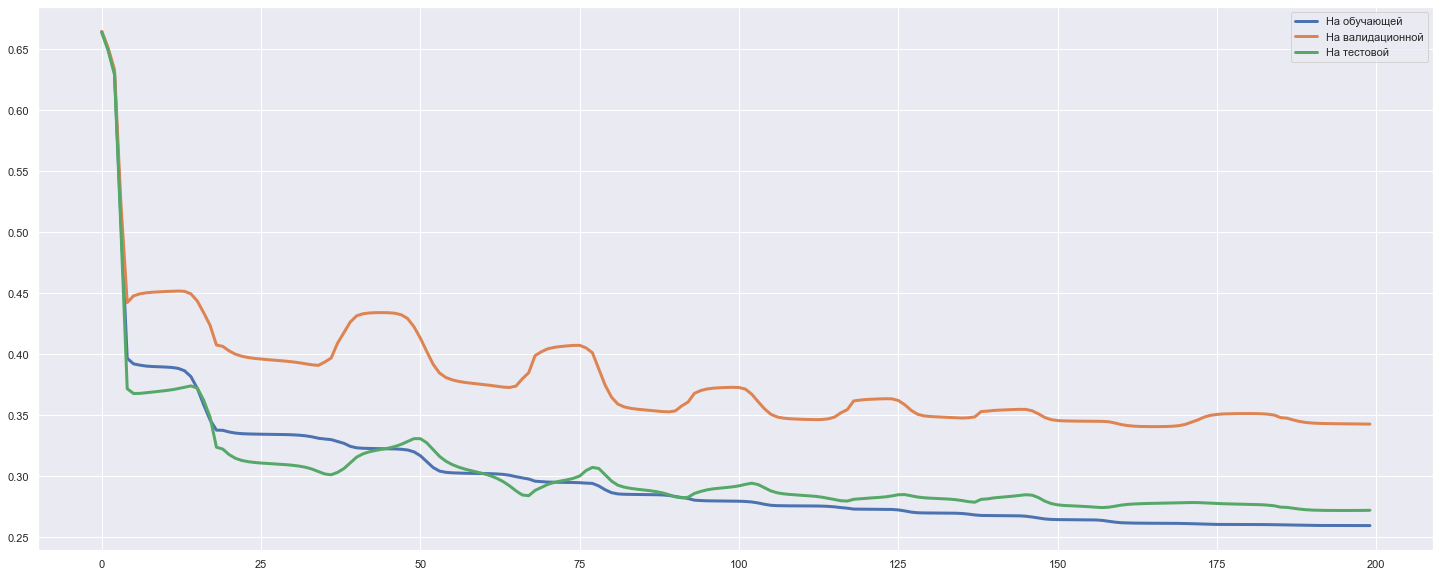

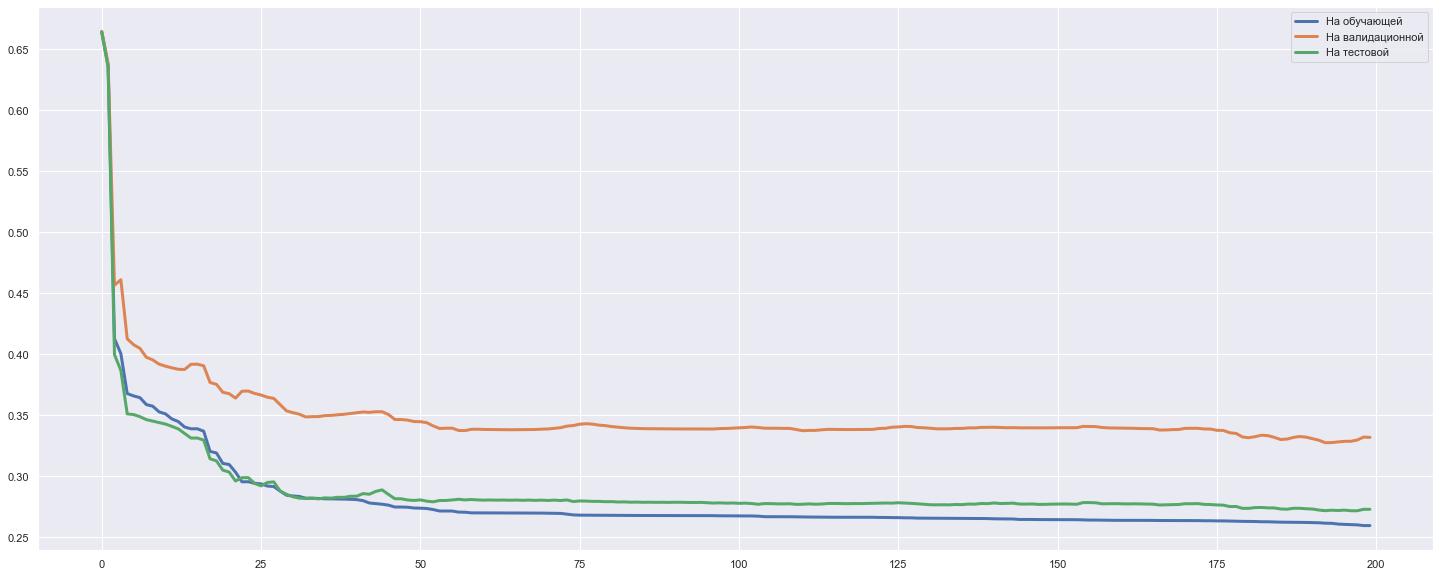

In [32]:
neupy_show_tvt_values(error_collector_FR)
neupy_show_tvt_values(error_collector_PR)

#### б) Заполнить таблицу по результатам обучения

In [33]:
print("Fletcher-Reeeves", info_FR[0], round(info_FR[1], 3), round(info_FR[2], 3))
print("Polak-Ribiere", info_PR[0], round(info_PR[1], 3), round(info_PR[2], 3))

Fletcher-Reeeves 35 0.331 0.304
Polak-Ribiere 58 0.271 0.281


### 4.5. Исследование метода AdaGrad

In [34]:
info_Adagrad, error_collector = keras_train_and_get_info(
    keras.optimizers.Adagrad(lr=train_params["learning_rate"])
)

#### а) Кривые обучения

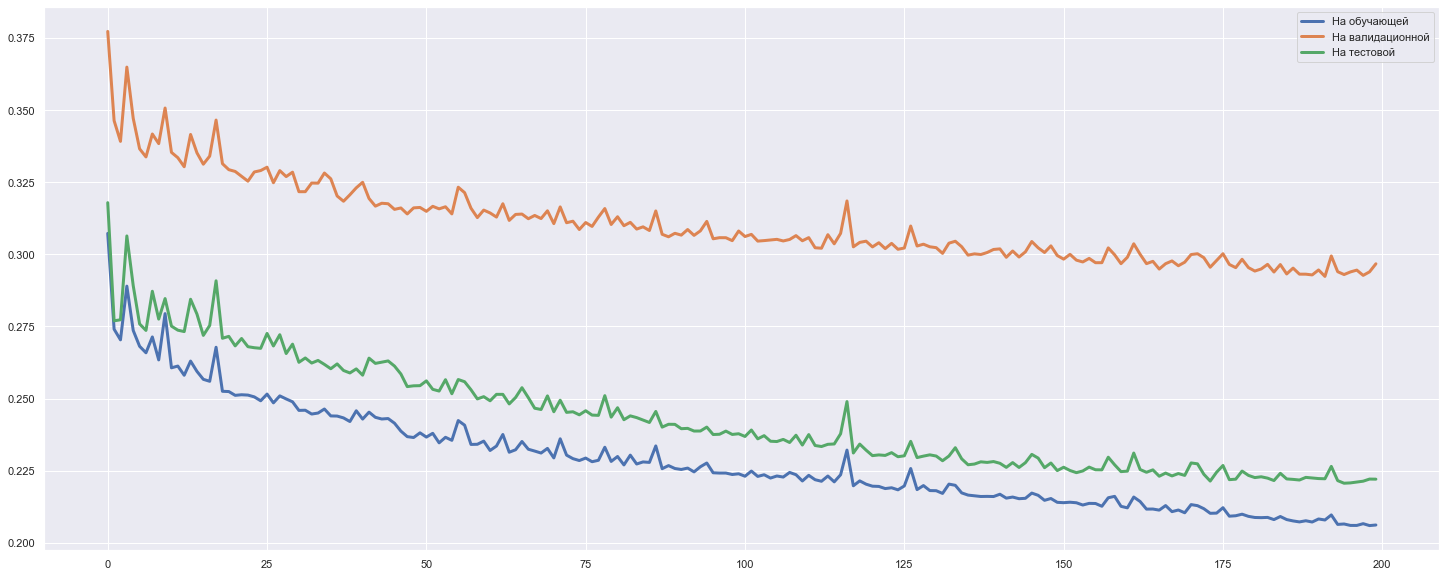

In [35]:
keras_show_tvt_values(error_collector)

#### б) Исследование динамики скорости обучения

In [36]:
print("AdaGrad"), 
print(info_Adagrad[0]), 
print(round(info_Adagrad[1], 3)), 
print(round(info_Adagrad[2], 3))

AdaGrad
103
0.223
0.236


### 4.6. Исследование методов RMSProp и AdaDelta

In [37]:
rho_RMSprop_AdaDelta = [0.8, 0.85, 0.9, 0.95]
info_and_error_collector_RMSProp = [
    keras_train_and_get_info(
        keras.optimizers.RMSprop(lr=train_params["learning_rate"], rho = rho)
    )
    for rho in rho_RMSprop_AdaDelta
]
info_and_error_collector_AdaDelta = [
    keras_train_and_get_info(
        keras.optimizers.Adadelta(lr=train_params["learning_rate"], rho = rho)
    )
    for rho in rho_RMSprop_AdaDelta
]

#### а) Сравнение кривых обучения

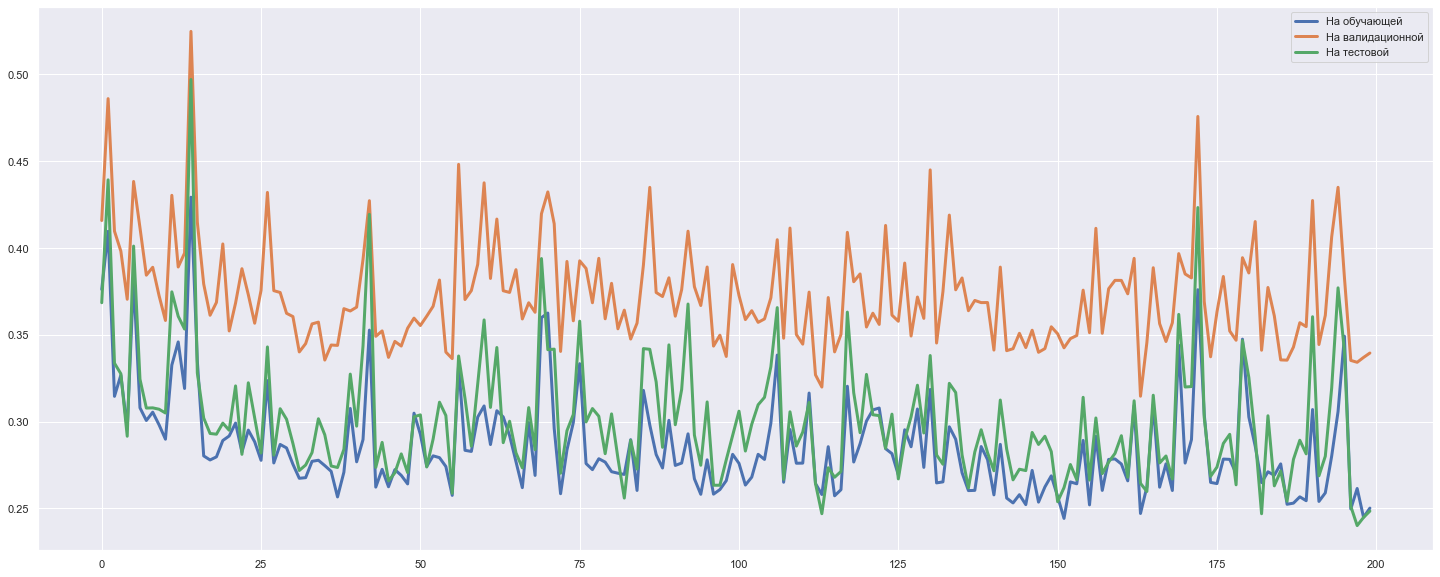

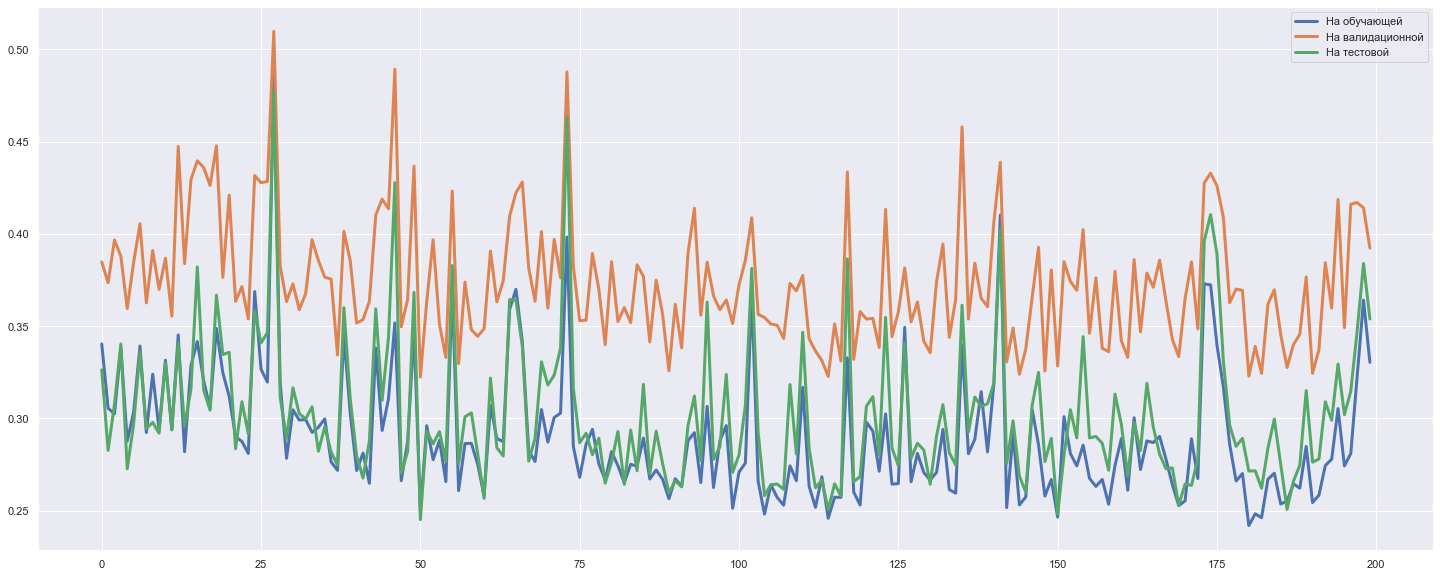

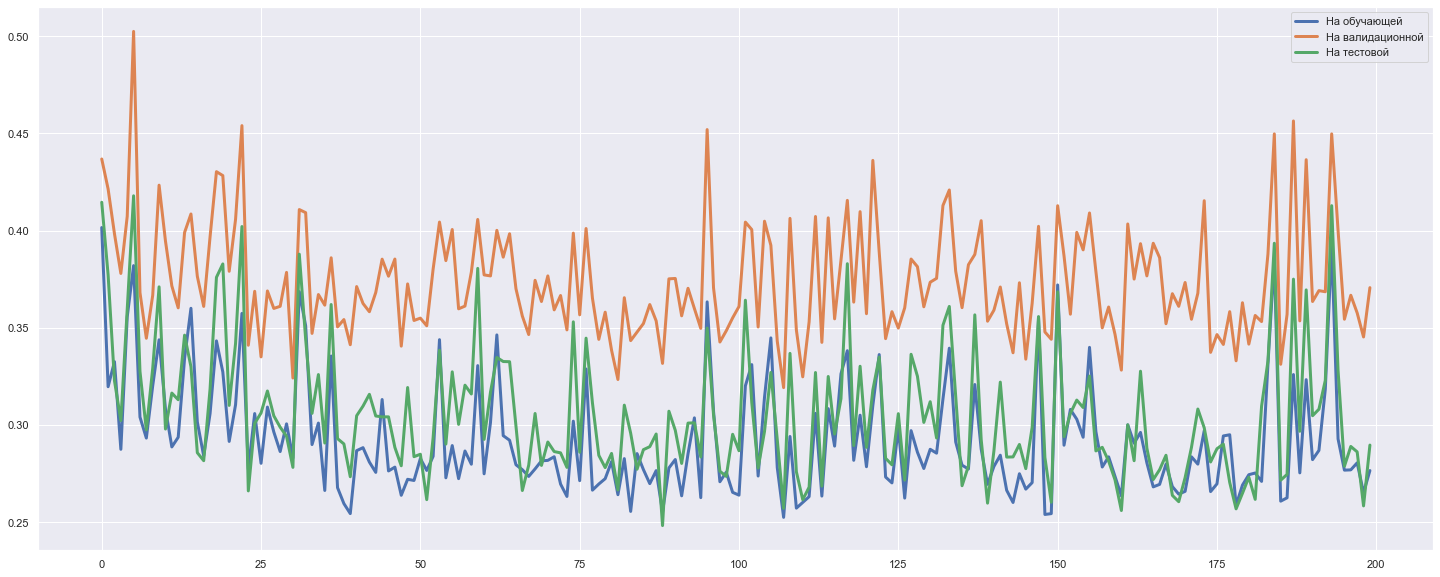

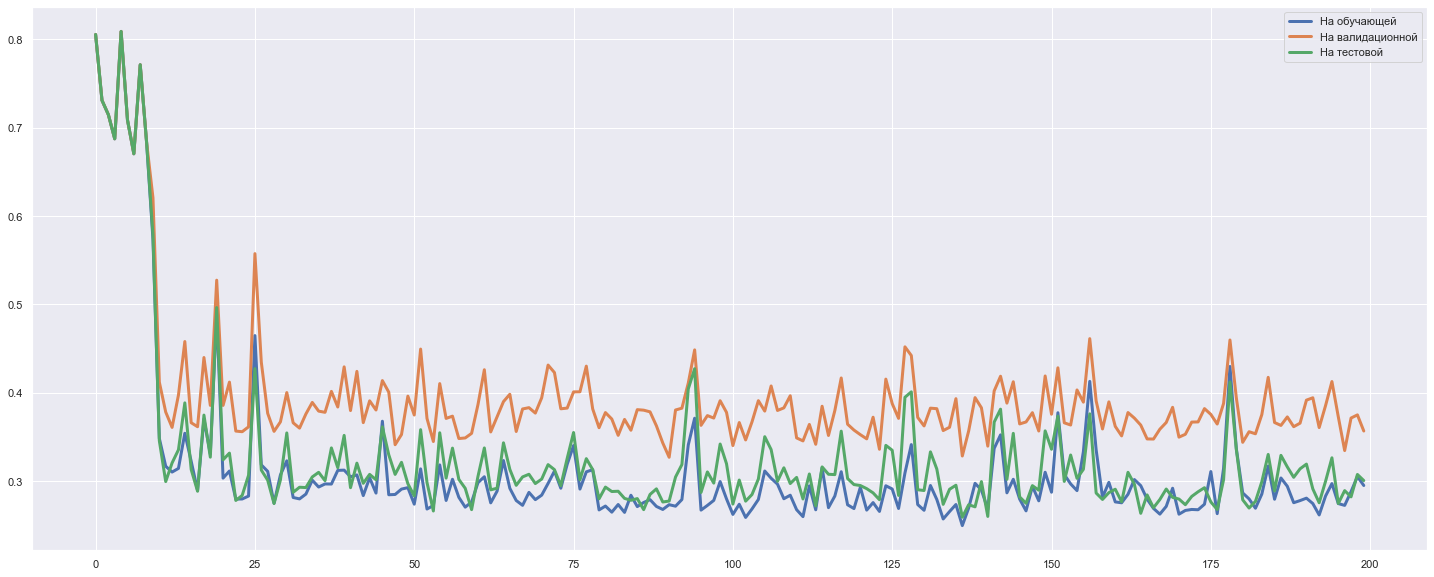

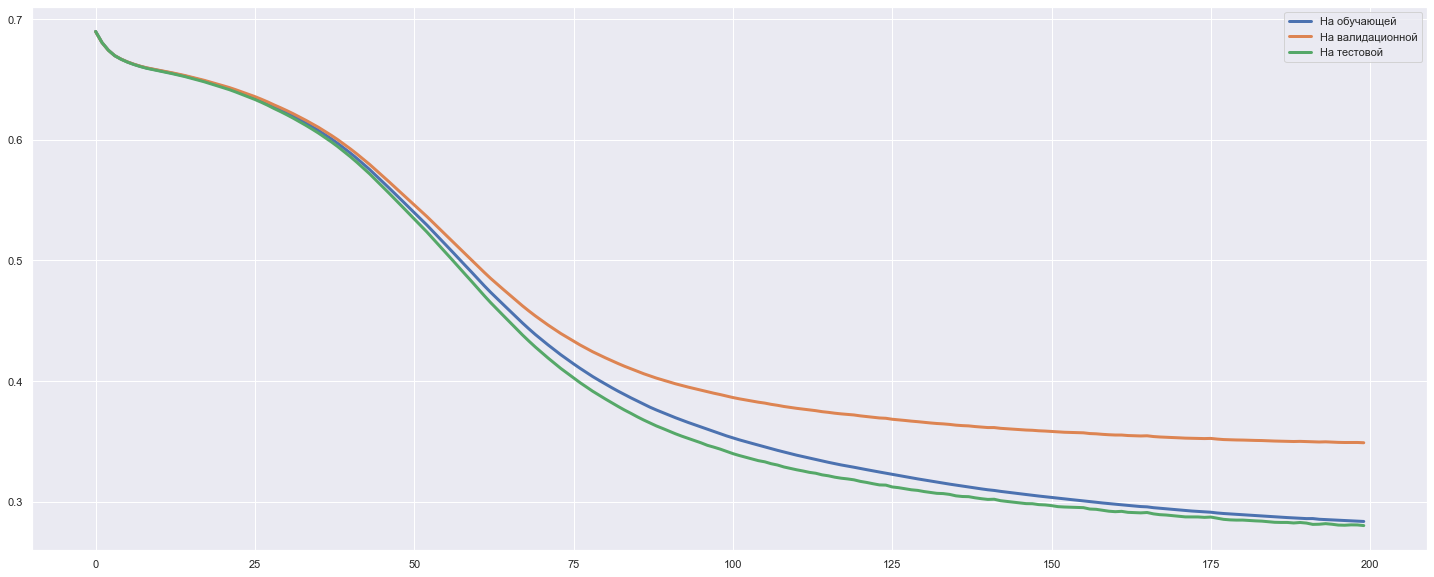

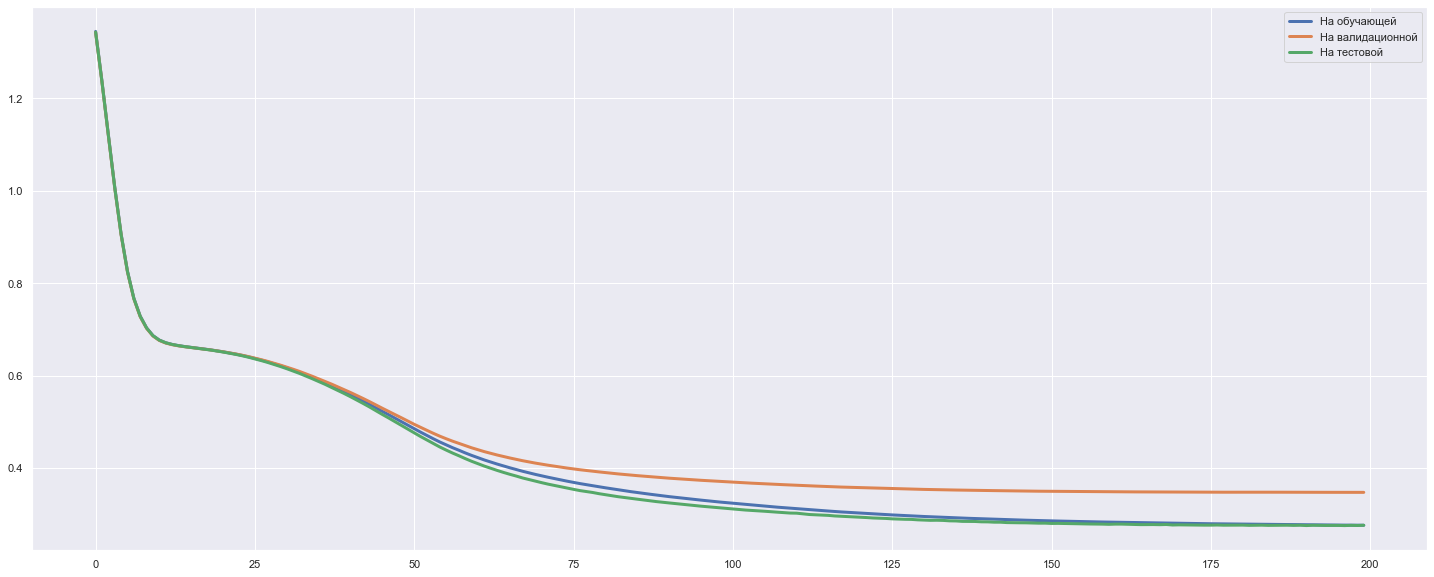

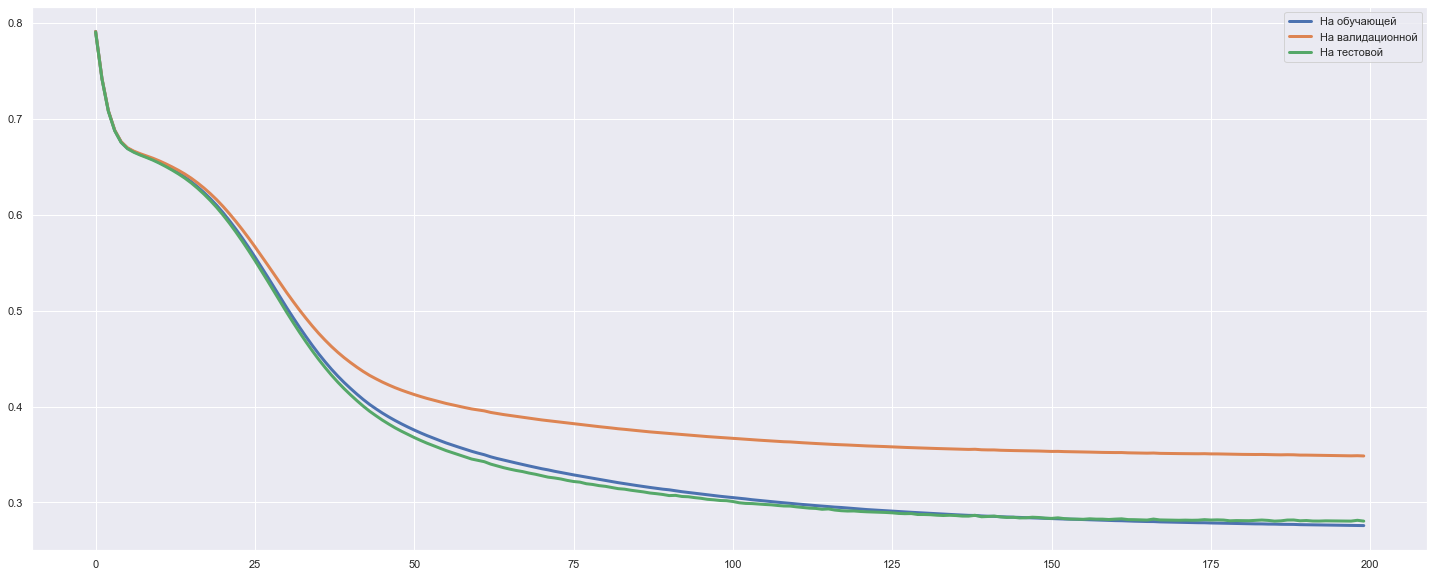

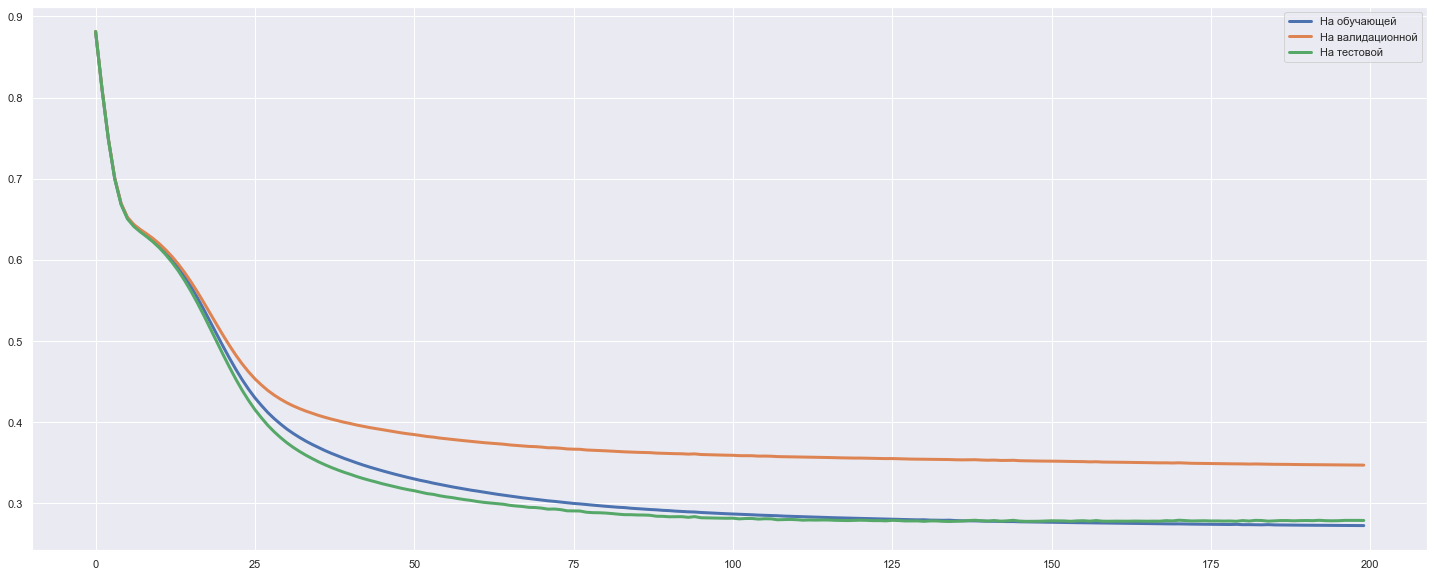

In [38]:
for i_and_ec in info_and_error_collector_RMSProp:
    keras_show_tvt_values(i_and_ec[1])
for i_and_ec in info_and_error_collector_AdaDelta:
    keras_show_tvt_values(i_and_ec[1])

#### б) Исследование динамики скорости обучения

In [39]:
for i in range(0, 2*len(rho_RMSprop_AdaDelta)):
            print(i+1,
            "RMSProp" if i % 2 == 0 else "AdaDelta",
            rho_RMSprop_AdaDelta[i // 2],
            info_and_error_collector_RMSProp[i // 2][0][0] if i % 2 == 0 else info_and_error_collector_AdaDelta[i // 2][0][0],
            round(info_and_error_collector_RMSProp[i // 2][0][1], 3) if i % 2 == 0 else round(info_and_error_collector_AdaDelta[i // 2][0][1], 3),
            round(info_and_error_collector_RMSProp[i // 2][0][2], 3) if i % 2 == 0 else round(info_and_error_collector_AdaDelta[i // 2][0][2], 3))

1 RMSProp 0.8 21 0.292 0.295
2 AdaDelta 0.8 200 0.284 0.28
3 RMSProp 0.85 24 0.281 0.292
4 AdaDelta 0.85 199 0.276 0.275
5 RMSProp 0.9 26 0.28 0.306
6 AdaDelta 0.9 200 0.276 0.281
7 RMSProp 0.95 24 0.28 0.284
8 AdaDelta 0.95 200 0.273 0.279


#### г) Выводы

In [40]:
def get_best_rho_RMSProp():
    index = 0
    val_loss = 1
    for i in range(0, len(info_and_error_collector_RMSProp)):
        if info_and_error_collector_RMSProp[i][0][2] < val_loss:
            val_loss = info_and_error_collector_RMSProp[i][0][2]
            index = i
    return rho_RMSprop_AdaDelta[index]

train_params["rho_RMSProp"] = get_best_rho_RMSProp()
print("Лучшее значение $\\rho$ = {}".format(train_params["rho_RMSProp"]))

Лучшее значение $\rho$ = 0.95


In [41]:
def get_best_rho_AdaDelta():
    index = 0
    val_loss = 1
    for i in range(0, len(info_and_error_collector_AdaDelta)):
        if info_and_error_collector_AdaDelta[i][0][2] < val_loss:
            val_loss = info_and_error_collector_AdaDelta[i][0][2]
            index = i
    return rho_RMSprop_AdaDelta[index]

train_params["rho_AdaDelta"] = get_best_rho_AdaDelta()
print("Лучшее значение $\\rho$ = {}".format(train_params["rho_AdaDelta"]))

Лучшее значение $\rho$ = 0.85


### 4.7. Исследование метода Adam

In [42]:
betas_Adam = [
    [train_params["rho_RMSProp"], train_params["rho_RMSProp"]],
    [train_params["rho_AdaDelta"], train_params["rho_AdaDelta"]], 
    [0.9, 0.999], 
    [0.85, 0.9],
    [0.95, 0.9],
    [0.999, 0.999]
]
info_and_error_collector_Adam = [
    keras_train_and_get_info(
        keras.optimizers.Adam(lr=train_params["learning_rate"], beta_1=betas[0], beta_2=betas[1])
    )
    for betas in betas_Adam
]

#### а) Сравнение кривых обучения

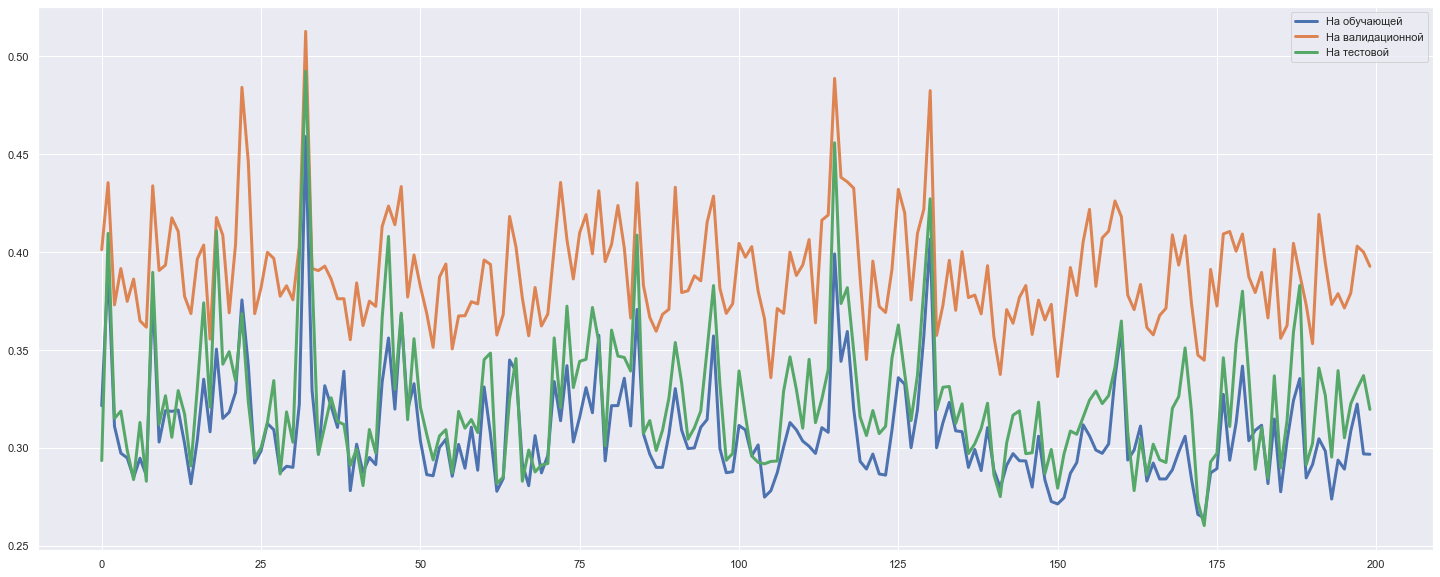

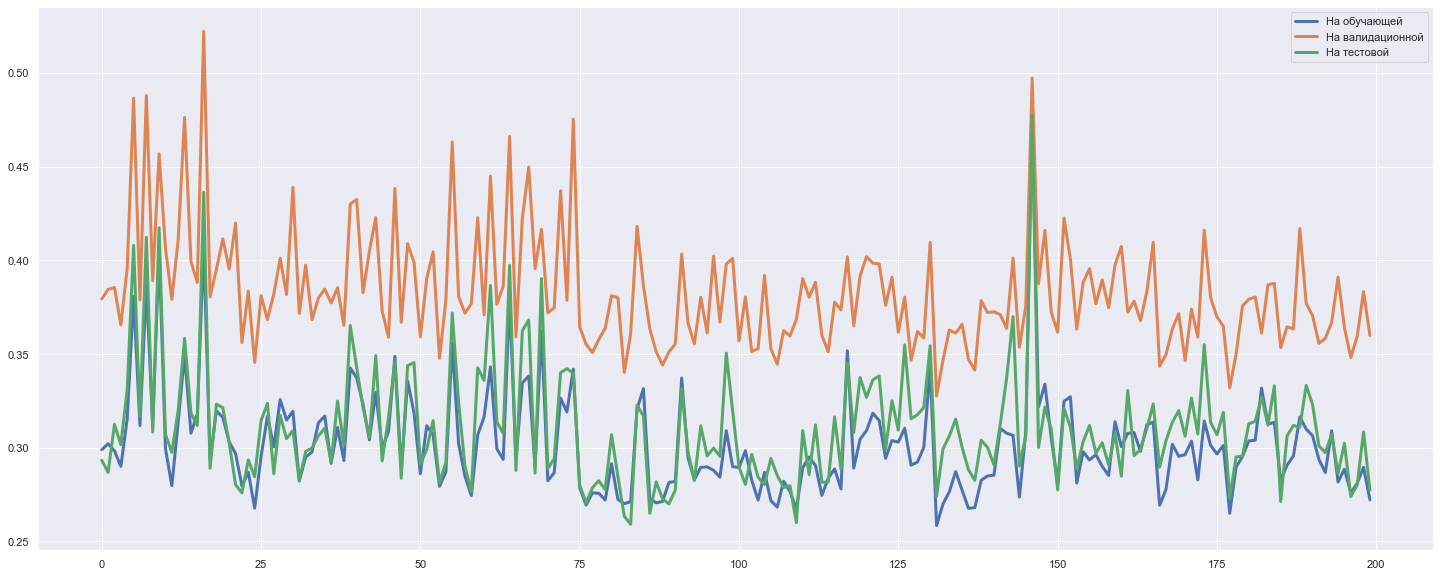

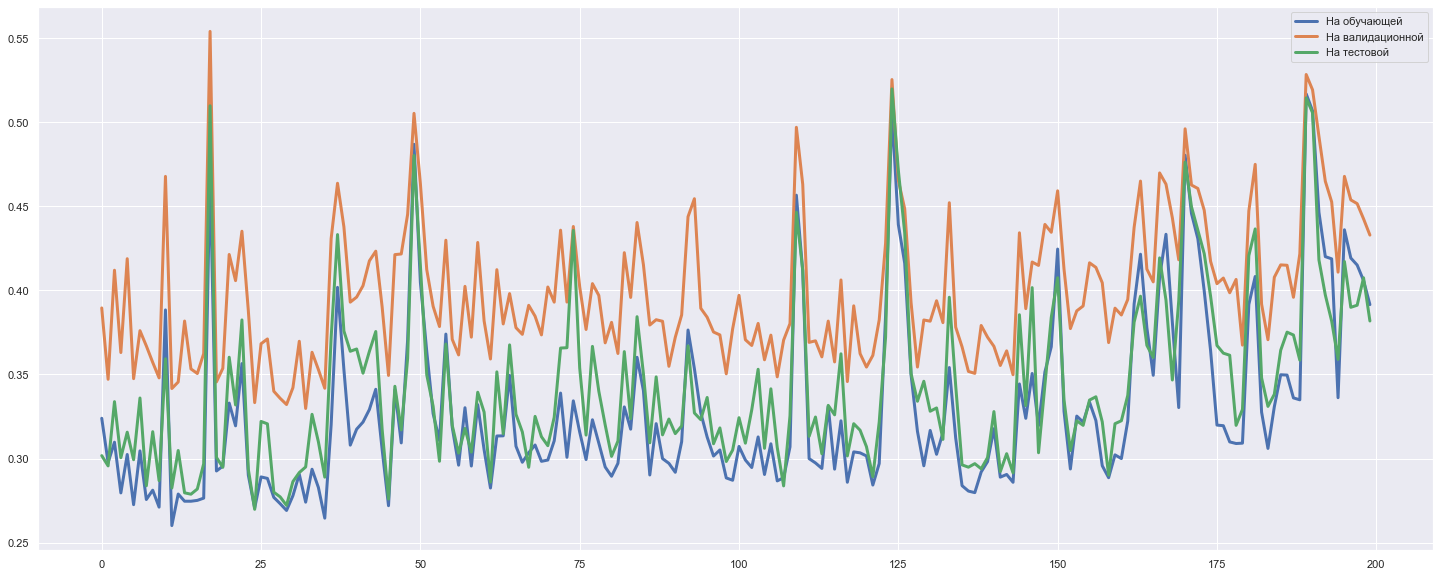

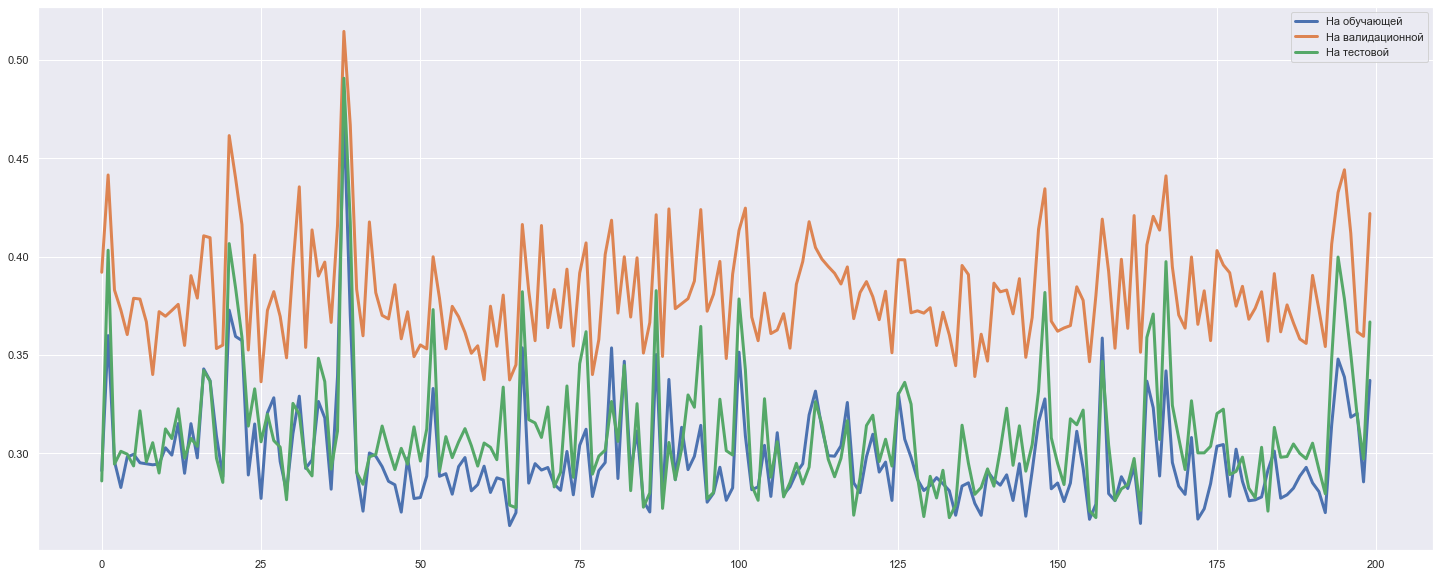

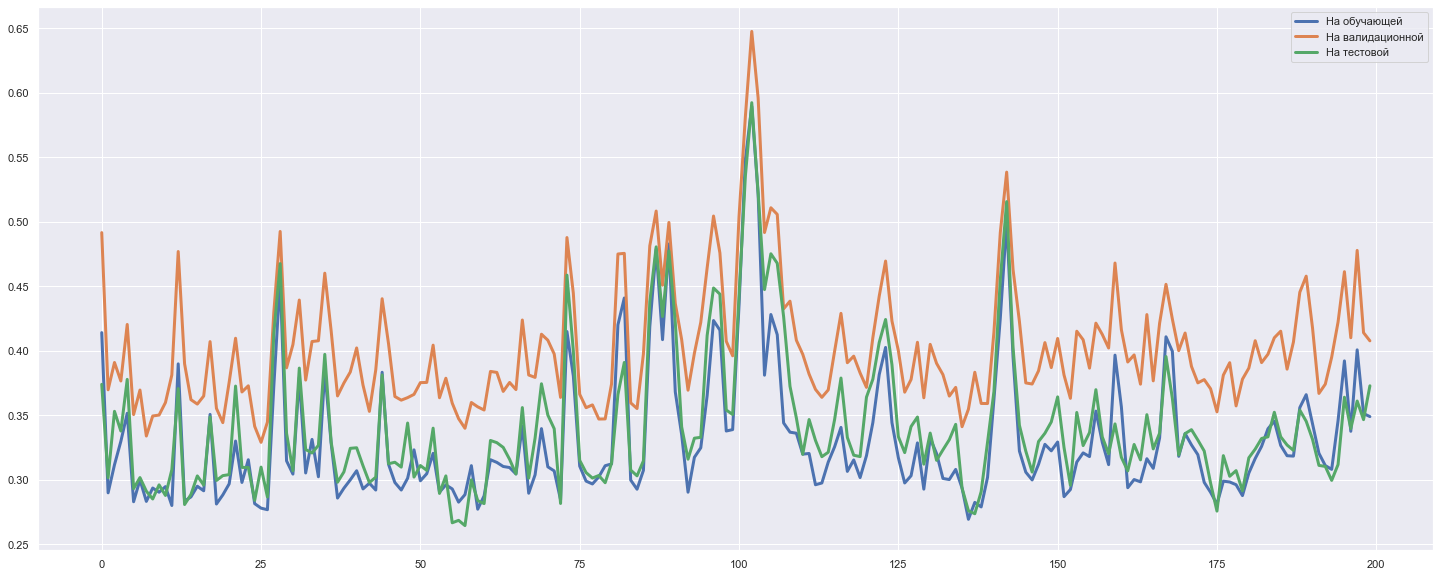

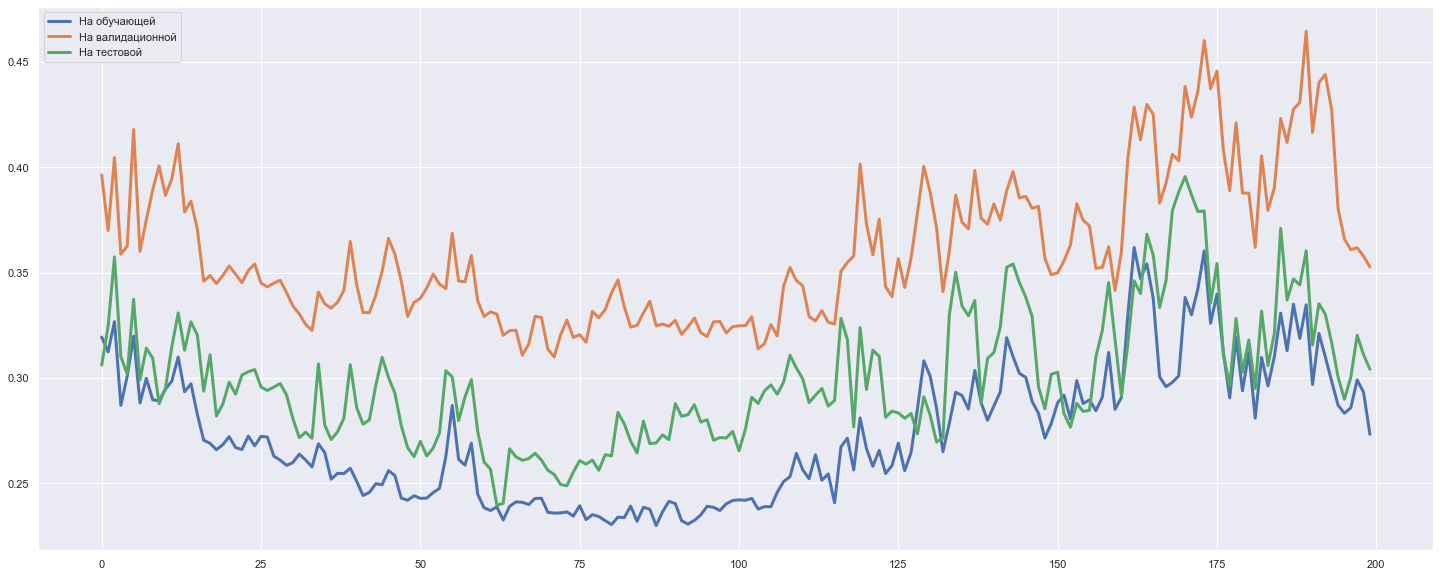

In [43]:
for i_and_ec in info_and_error_collector_Adam:
    keras_show_tvt_values(i_and_ec[1])

#### б) Исследование динамики скорости обучения

In [44]:
for i in range(0, len(info_and_error_collector_Adam)):
          print(  i+1, 
            betas_Adam[i][0],
            betas_Adam[i][1],
            info_and_error_collector_Adam[i][0][0], 
            round(info_and_error_collector_Adam[i][0][1], 3), 
            round(info_and_error_collector_Adam[i][0][2], 3))

1 0.95 0.95 18 0.308 0.321
2 0.85 0.85 4 0.29 0.302
3 0.9 0.999 12 0.26 0.282
4 0.85 0.9 9 0.294 0.305
5 0.95 0.9 8 0.283 0.291
6 0.999 0.999 34 0.258 0.271


#### г) Выводы

In [45]:
def get_best_betas():
    index = 0
    val_loss = 1
    for i in range(0, len(info_and_error_collector_Adam)):
        if info_and_error_collector_Adam[i][0][2] < val_loss:
            val_loss = info_and_error_collector_Adam[i][0][2]
            index = i
    return betas_Adam[index]

train_params["betas"] = get_best_betas()
print("Лучшее значение $\\beta_1$ = {}, $\\beta_2$ = {}".format(train_params["betas"][0], train_params["betas"][1]))

Лучшее значение $\beta_1$ = 0.999, $\beta_2$ = 0.999


### 4.9. Исследование методов Левенберга-Маркардта и BFGS


In [46]:
flag_use_MSE = True
info_LM, error_collector_LM = neupy_train_and_get_info("LM")
flag_use_MSE = False

In [47]:
info_BFGS, error_collector_BFGS = neupy_train_and_get_info("BFGS")

#### а) Кривые обучения

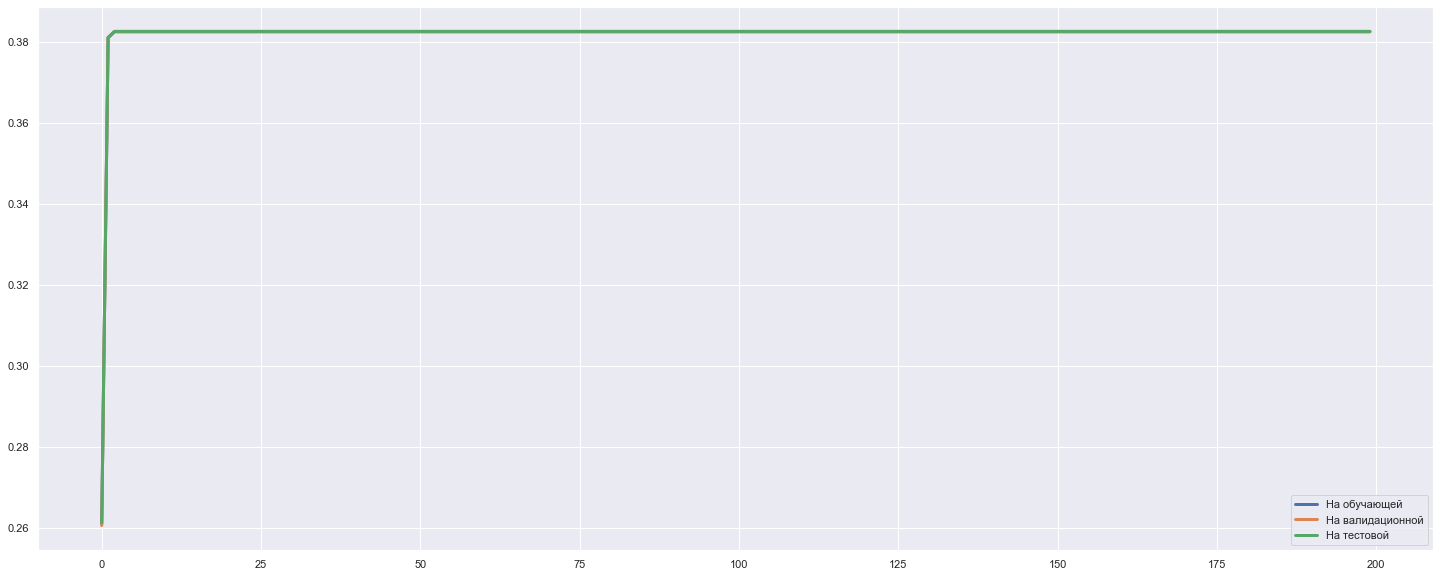

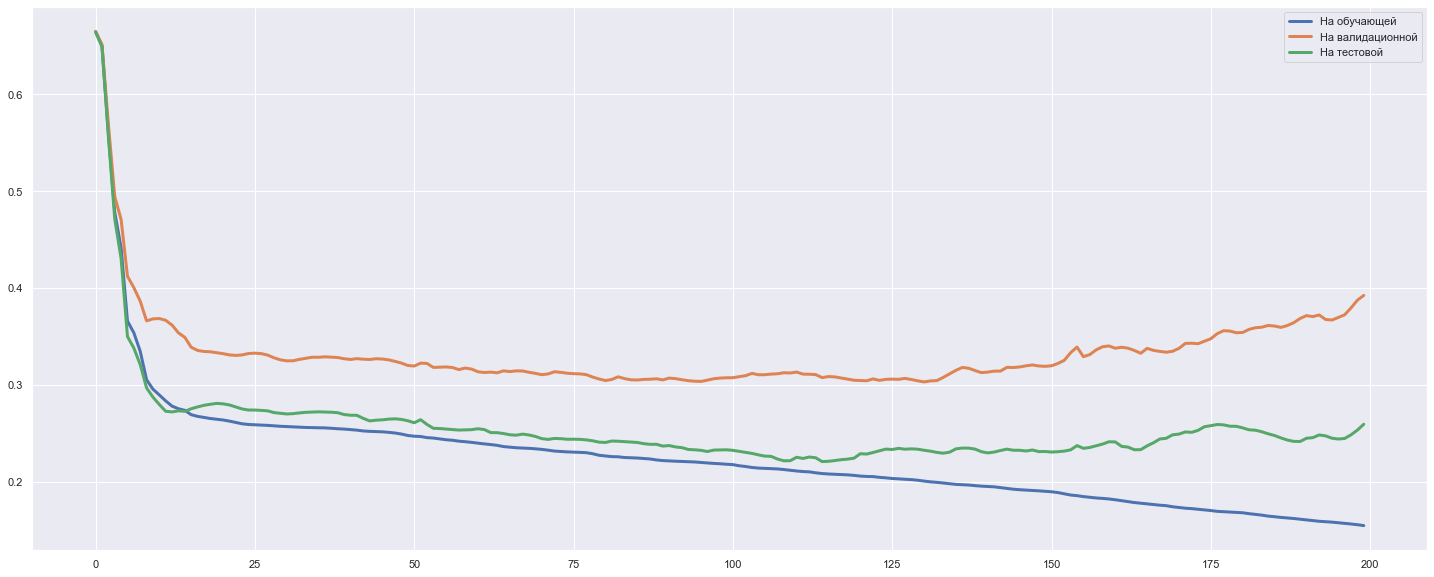

In [48]:
neupy_show_tvt_values(error_collector_LM)
neupy_show_tvt_values(error_collector_BFGS)

#### б) Заполнить таблицу по результатам обучения

In [49]:
print([1, "LM"]+info_LM)
print([2, "BFGS"]+info_BFGS)

[1, 'LM', 1, 0.26108324402408634, 0.2612461435706883]
[2, 'BFGS', 96, 0.21989521266406306, 0.23245625281007962]


### 4.10. Исследование метода стохастического градиента

In [50]:
batch_sizes_SGD = [1, 20, 100, len(v_train["x"])]
info_stohastic_GD = []
error_collector_GD = []
for batch_size in batch_sizes_SGD:
    temp = train_params["batch"]
    train_params["batch"] = batch_size
    info_and_error_collector = keras_train_and_get_info(
        keras.optimizers.SGD(lr=train_params["learning_rate"])
    )
    train_params["batch"] = temp
    info_stohastic_GD.append(info_and_error_collector[0])
    error_collector_GD.append(info_and_error_collector[1])

#### а) Сравнение кривых обучения

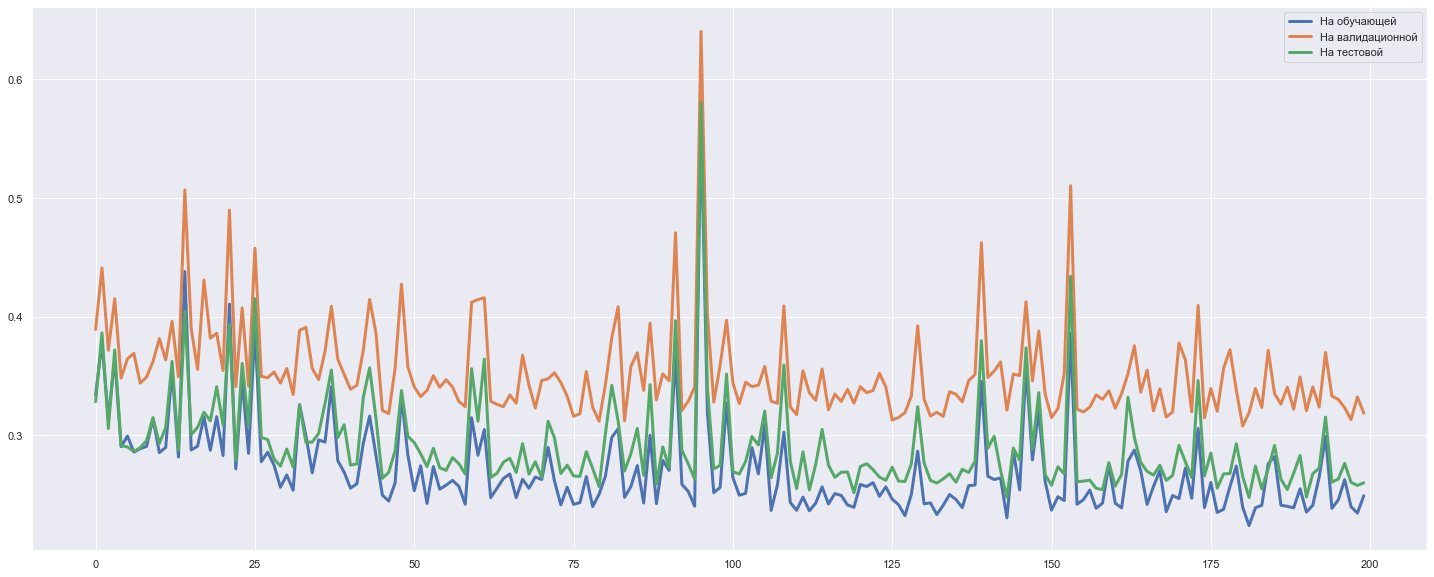

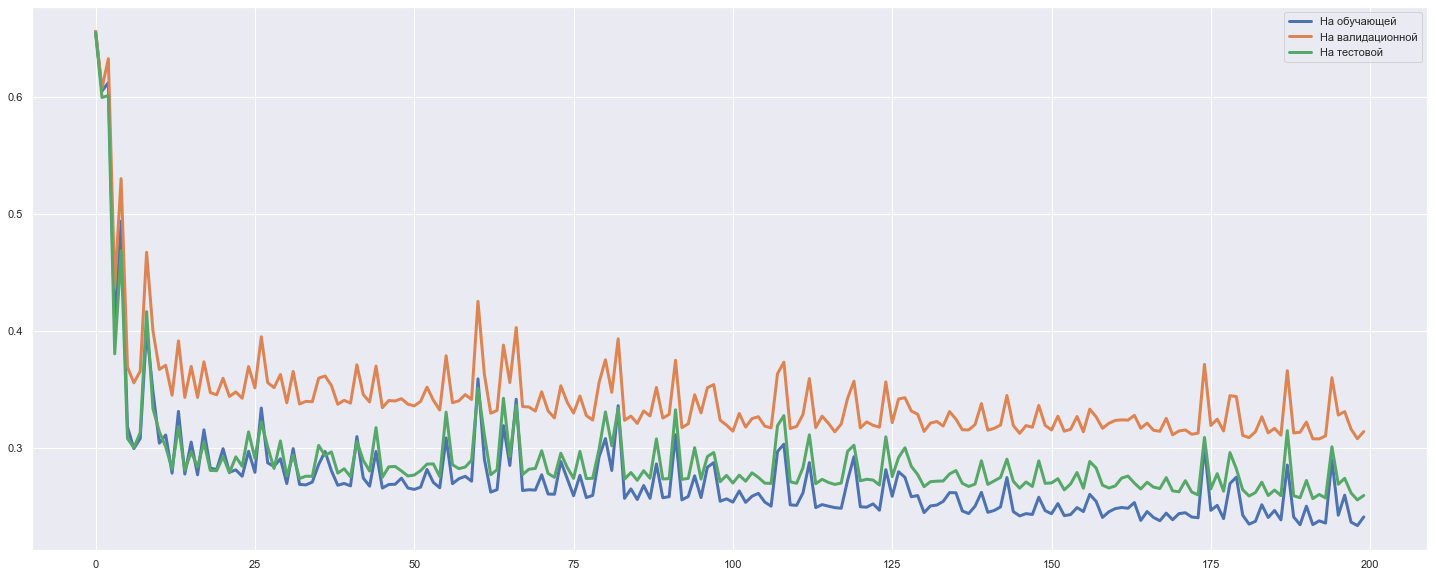

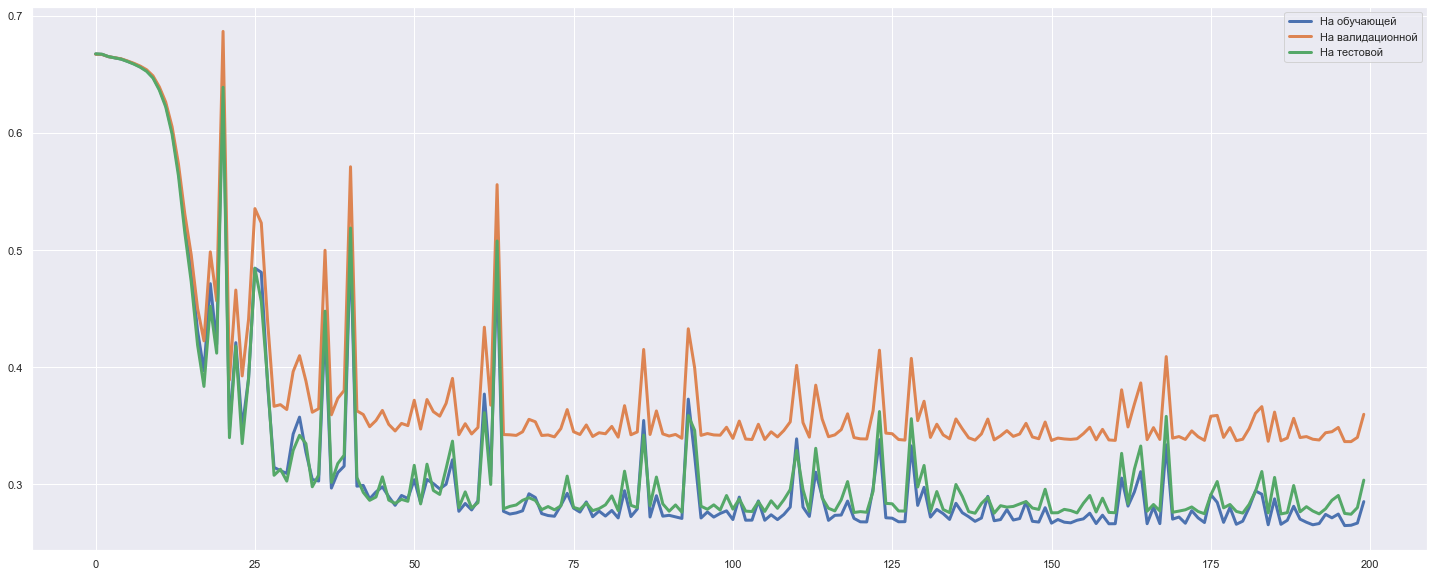

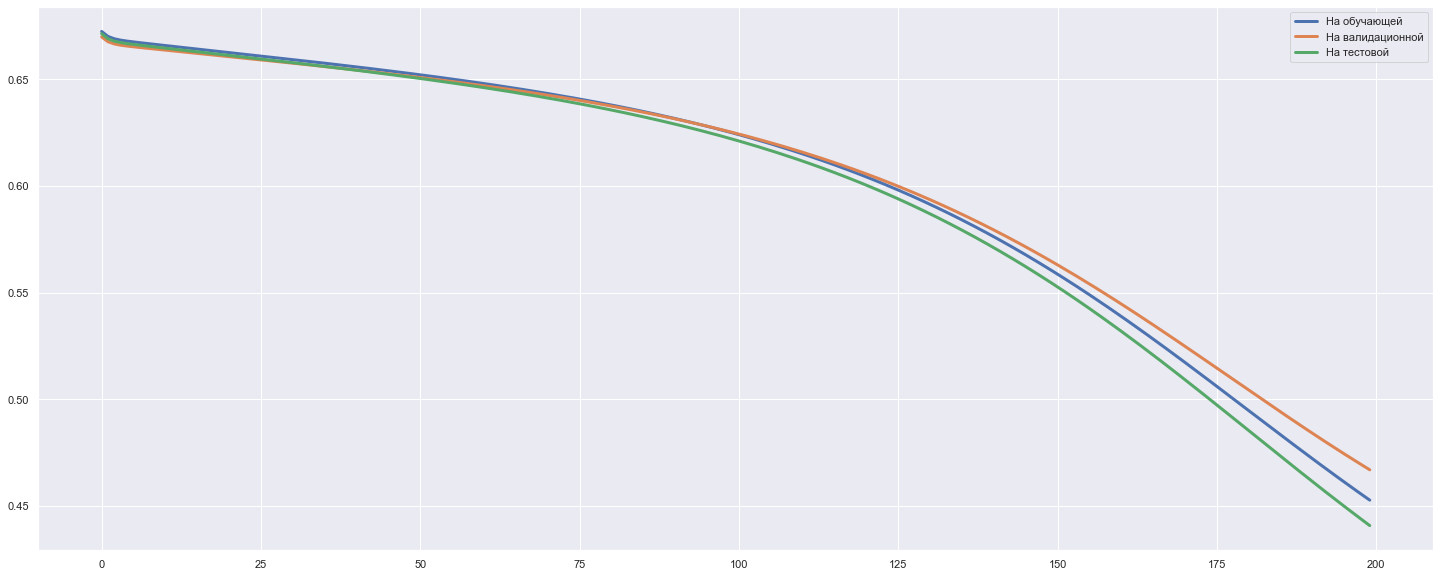

In [51]:
for ec in error_collector_GD:
    keras_show_tvt_values(ec)

#### б) Заполнить таблицу по результатам обучения

In [52]:
for i in range(0, len(info_stohastic_GD)):
    print(
            i+1,
            "GD",
            batch_sizes_SGD[i],
            info_stohastic_GD[i][0],
            round(info_stohastic_GD[i][1], 3),
            round(info_stohastic_GD[i][2], 3))

1 GD 1 23 0.272 0.278
2 GD 20 39 0.268 0.278
3 GD 100 48 0.282 0.284
4 GD 2398 200 0.453 0.441


#### в) Исследование влияния размера mini-batch’а на качество обучения

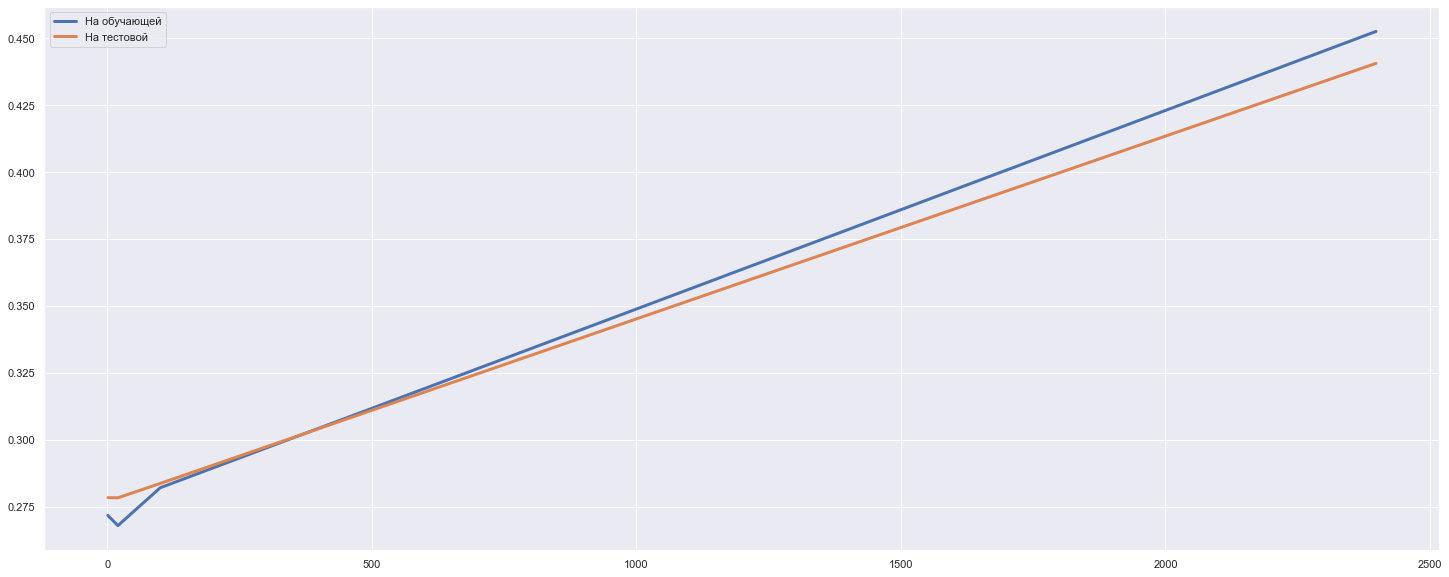

In [53]:
def keras_show_influence_on_SGD():
    _, picture = plt.subplots(figsize=(25,10))
    _ = picture.plot(batch_sizes_SGD, [info[1] for info in info_stohastic_GD], lw=3, label="На обучающей")
    _ = picture.plot(batch_sizes_SGD, [info[2] for info in info_stohastic_GD], lw=3, label="На тестовой")
    _ = picture.legend()
keras_show_influence_on_SGD()

In [54]:
def get_best_batch():
    index = 0
    val_loss = 1
    for i in range(0, len(info_stohastic_GD)):
        if info_stohastic_GD[i][2] < val_loss:
            val_loss = info_SGD[i][2]
            index = i
    return batch_sizes_SGD[index]

train_params["best_batch"] = get_best_batch()

### 4.11. Сравнение методов обучения

In [55]:
info_all_methods = [
    ["GD"]+info_SGD[learning_rates_SGD.index(train_params["learning_rate"])],
    ["GDM"]+info_GDM[moments_GDM_NAG.index(train_params["momentum_GDM"])],
    ["NAG"]+info_NAG[moments_GDM_NAG.index(train_params["momentum_NAG"])],
    #["SteepestGD"]+info_SteepGD,
    ["Fletcher-Reeeves"]+info_FR,
    ["Polak-Ribiere"]+info_PR,
    ["AdaGrad"]+info_Adagrad,
    ["RMSProp"]+info_and_error_collector_RMSProp[rho_RMSprop_AdaDelta.index(train_params["rho_RMSProp"])][0],
    ["AdaDelta"]+info_and_error_collector_AdaDelta[rho_RMSprop_AdaDelta.index(train_params["rho_AdaDelta"])][0],
    ["Adam"]+info_and_error_collector_Adam[betas_Adam.index(train_params["betas"])][0],
    #["RProp"]+info_RProp,
    ["LM"]+info_LM,
    ["BFGS"]+info_BFGS,
    ["StohasticGD"]+info_stohastic_GD[batch_sizes_SGD.index(train_params["best_batch"])]
]
info_all_methods


[['GD', 48, 0.2715083658695221, 0.2760087847709656],
 ['GDM', 42, 0.27354809641838074, 0.27728962898254395],
 ['NAG', 36, 0.25708597898483276, 0.26808005571365356],
 ['Fletcher-Reeeves', 35, 0.33123209573222856, 0.3038941690232605],
 ['Polak-Ribiere', 58, 0.2706613916887908, 0.28074239154462705],
 ['AdaGrad', 103, 0.2230209857225418, 0.2360408753156662],
 ['RMSProp', 24, 0.27988100051879883, 0.2839440703392029],
 ['AdaDelta', 199, 0.2759898006916046, 0.27540162205696106],
 ['Adam', 34, 0.2577388286590576, 0.2713281512260437],
 ['LM', 1, 0.26108324402408634, 0.2612461435706883],
 ['BFGS', 96, 0.21989521266406306, 0.23245625281007962],
 ['StohasticGD', 48, 0.2820863127708435, 0.28370144963264465]]

In [56]:
print( ["$\\alpha$", train_params["learning_rate"]],
        ["GDM momentum", train_params["momentum_GDM"]],
        ["NAG momentum", train_params["momentum_NAG"]],
        ["RMSProp $\\rho$", train_params["rho_RMSProp"]],
        ["AdaDelta $\\rho$", train_params["rho_AdaDelta"]],
        ["Adam [$\\beta_1, \\beta_2$]", train_params["betas"]],
        ["StohasticGD batch", train_params["best_batch"]])


['$\\alpha$', 0.1] ['GDM momentum', 0.1] ['NAG momentum', 0.9] ['RMSProp $\\rho$', 0.95] ['AdaDelta $\\rho$', 0.85] ['Adam [$\\beta_1, \\beta_2$]', [0.999, 0.999]] ['StohasticGD batch', 100]


#### а) Сравнение числа эпох обучения

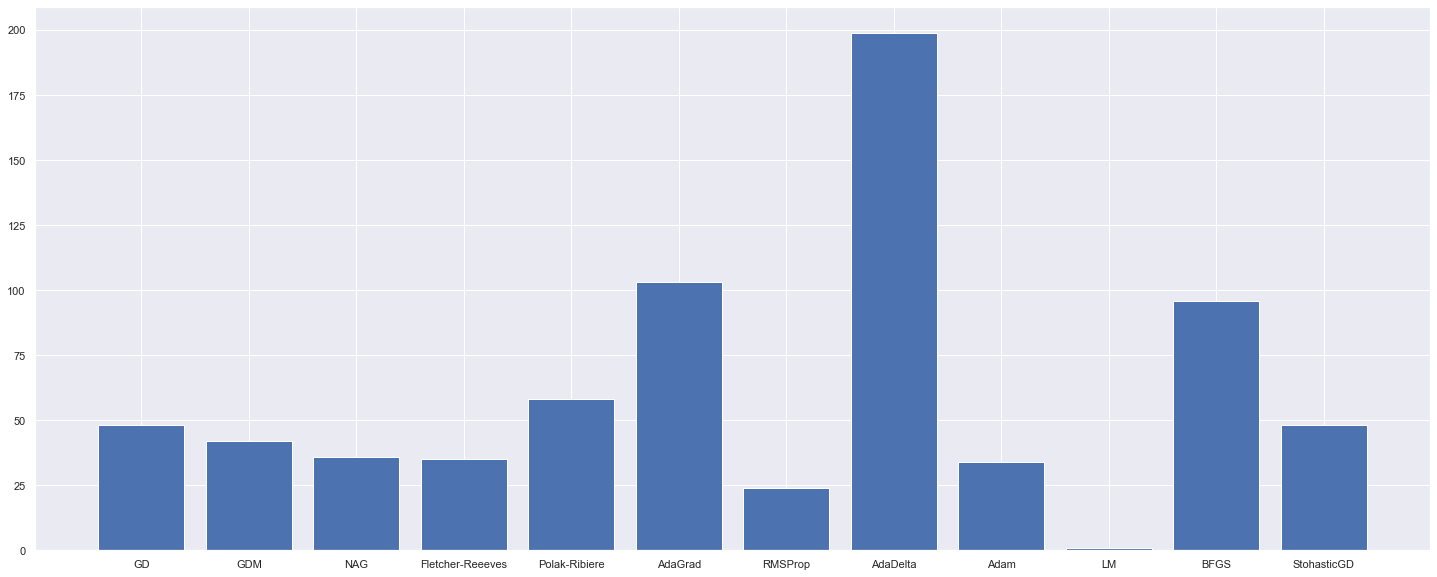

In [57]:
_, picture = plt.subplots(figsize=(25,10))
_ = picture.bar(
    [info_all_methods[i][0] for i in range(0, len(info_all_methods))],
    [info_all_methods[i][1] for i in range(0, len(info_all_methods))]
)

#### б) Сравнение качества обученных нейросетевых моделей

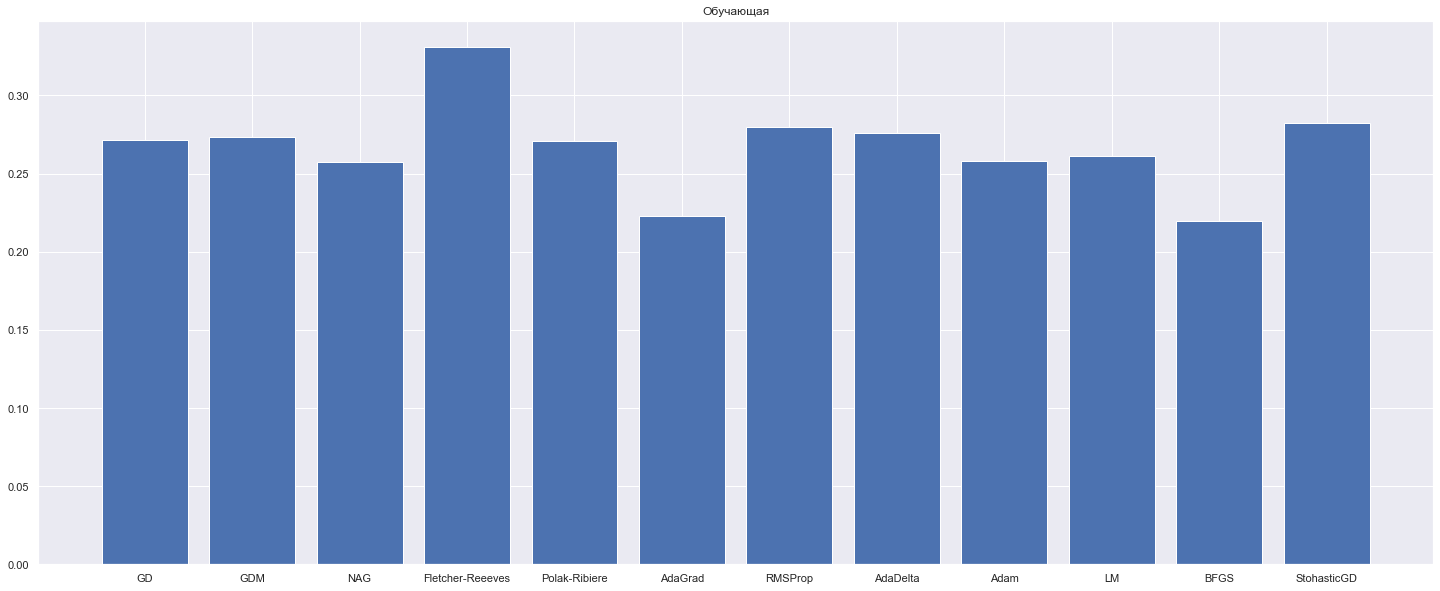

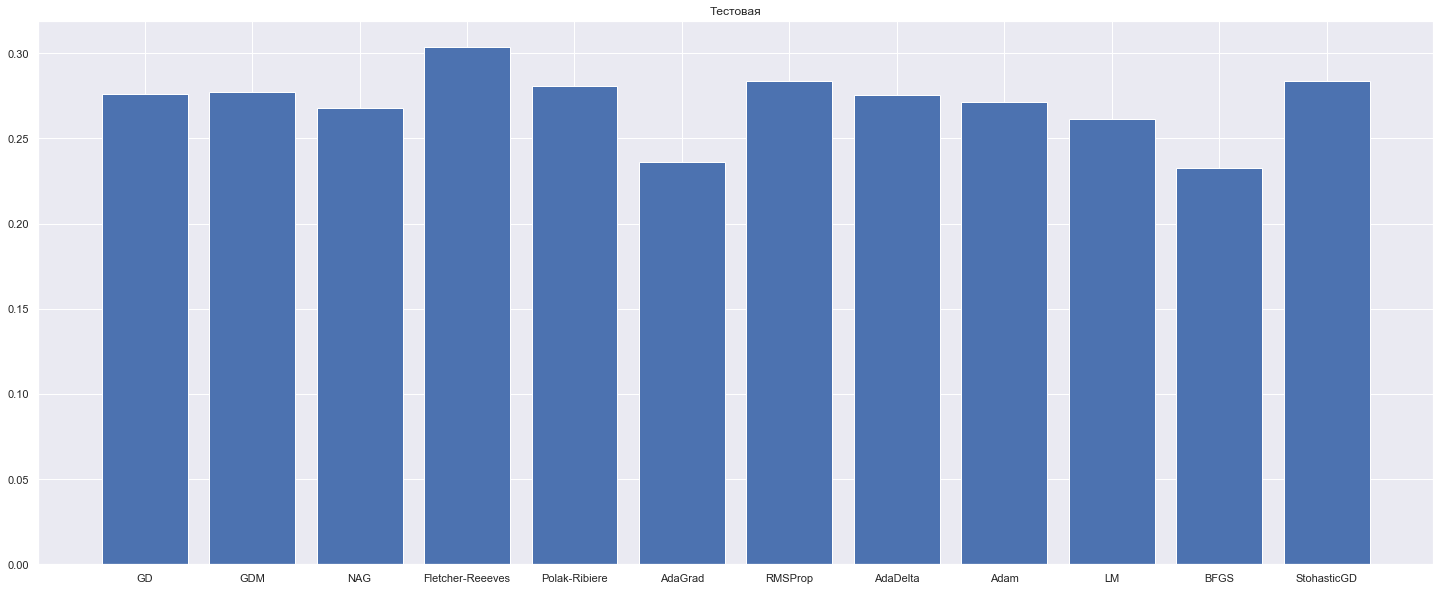

In [58]:
_, picture = plt.subplots(figsize=(25,10))
_ = picture.bar(
    [info_all_methods[i][0] for i in range(0, len(info_all_methods))],
    [info_all_methods[i][2] for i in range(0, len(info_all_methods))]
)
_ = picture.set_title("Обучающая")
_, picture = plt.subplots(figsize=(25,10))
_ = picture.bar(
    [info_all_methods[i][0] for i in range(0, len(info_all_methods))],
    [info_all_methods[i][3] for i in range(0, len(info_all_methods))]
)
_ = picture.set_title("Тестовая")

### 4.13. Методы кросс-валидации

In [59]:
def cv_monte_carlo():
    cv_info_MK = []
    for i in range(0, 10):
        x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(train_attrs, results, test_size=0.3)
        m_x_train = v_train["x"]
        m_y_train = v_train["y"]
        m_x_valid = v_valid["x"]
        m_y_valid = v_valid["y"]
        m_x_test = v_test["x"]
        m_y_test = v_test["y"]
        v_train["x"] = x_train
        v_train["y"] = y_train
        v_valid["x"] = x_test
        v_valid["y"] = y_test
        v_test["x"] = x_test
        v_test["y"] = y_test
        info, _ = keras_train_and_get_info(keras.optimizers.SGD(lr=train_params["learning_rate"]))
        cv_info_MK.append(info)
        v_train["x"] = m_x_train
        v_train["y"] = m_y_train
        v_valid["x"] = m_x_valid
        v_valid["y"] = m_y_valid
        v_test["x"] = m_x_test
        v_test["y"] = m_y_test
    e_train = [info[1] for info in cv_info_MK]
    e_test = [info[2] for info in cv_info_MK]
    return [round(np.mean(e_train), 3), round(np.std(e_train), 3)], [round(np.mean(e_test), 3), round(np.std(e_test), 3)]

cross_valid_MC = cv_monte_carlo()

In [60]:
def cv_holdout():
    info, _ = keras_train_and_get_info(keras.optimizers.SGD(lr=train_params["learning_rate"]))
    return [round(info[1]), 0], [round(info[2]), 0]

cross_valid_Holdout = cv_holdout()

In [61]:
def cv_K_fold(k):
    cv_info_kfold = []
    skf = sklearn.model_selection.StratifiedKFold(k)
    folds = skf.split(train_attrs, results)
    for train_index, test_index in folds:
        m_x_train = v_train["x"]
        m_y_train = v_train["y"]
        m_x_valid = v_valid["x"]
        m_y_valid = v_valid["y"]
        m_x_test = v_test["x"]
        m_y_test = v_test["y"]

        v_train["x"] = train_attrs[train_index]
        v_train["y"] = results[train_index]
        v_valid["x"] = train_attrs[test_index]
        v_valid["y"] = results[test_index]
        v_test["x"] = v_valid["x"]
        v_test["y"] = v_valid["y"]
        
        x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(v_train["x"], v_train["y"], test_size=0.3)
        v_train["x"] = x_train
        v_train["y"] = y_train
        v_valid["x"] = x_test
        v_valid["y"] = y_test
        
        info, _ = keras_train_and_get_info(keras.optimizers.SGD(lr=train_params["learning_rate"]))
        cv_info_kfold.append(info)
        
        v_train["x"] = m_x_train
        v_train["y"] = m_y_train
        v_valid["x"] = m_x_valid
        v_valid["y"] = m_y_valid
        v_test["x"] = m_x_test
        v_test["y"] = m_y_test
    e_train = [info[1] for info in cv_info_kfold]
    e_test = [info[2] for info in cv_info_kfold]
    return [round(np.mean(e_train), 3), round(np.std(e_train), 3)], [round(np.mean(e_test), 3), round(np.std(e_test), 3)]

cross_valid_10fold = cv_K_fold(10)

#### а) Заполнить таблицу по результатам кросс-валидации различными методами

In [62]:
print(["Монте-Карло", 10, cross_valid_MC[0], cross_valid_MC[1]],
        ["Holdout 60/30/10", 1, cross_valid_Holdout[0], cross_valid_Holdout[1]],
        ["10-fold", 10, cross_valid_10fold[0], cross_valid_10fold[1]])

['Монте-Карло', 10, [0.294, 0.006], [0.29, 0.011]] ['Holdout 60/30/10', 1, [0, 0], [0, 0]] ['10-fold', 10, [0.295, 0.008], [0.31, 0.078]]
